# Model participants decisions (yes/no) for experiment 2
### using the same modeling framework as model 1

## Load Dataset

In [6]:
import pandas as pd
import statsmodels.api as sm
import os
import json
import ast
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import LinearRegression
from scipy.stats import binned_statistic_2d
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.colorbar import ColorbarBase
from matplotlib.cm import hsv
from shapely.geometry import Point, LineString
import pybrms
from similaritymeasures import frechet_dist
from scipy.stats import pearsonr
from scipy.stats import norm
from scipy.stats import multivariate_normal
import pickle
import subprocess
from scipy.optimize import minimize, Bounds
from pathlib import Path
from matplotlib.animation import FuncAnimation

# import logging
import itertools
# logging.basicConfig(level=logging.DEBUG,
#                     format='%(asctime)s - %(levelname)s - %(message)s')
# logging.disable(logging.CRITICAL)
from scipy.special import expit


# canvas settings
canvasWidth = 1000 
canvasHeight = 600
ball_Xs = [322.3, 322.3, 322.3, 322.3, 500 , 500 , 500 , 500 , 604.4, 604.4, 604.4, 604.4]
color_map = plt.get_cmap('viridis', 6)
green = color_map(4)
modeling_choice = 'Model_both_x_and_y'
fall_Direction = {1.0: 'left', 2.0: 'right', 3.0: 'right', 4.0: 'left', 
                 5.0: 'right', 6.0: 'right', 7.0: 'left', 8.0: 'left',
                 9.0: 'left', 10.0: 'right', 11.0: 'left', 12.0: 'right'}

segmented_line = [((250, 150), (250, 450)), ((250, 450), (750, 450)), ((750, 450), (750, 150))]
top_y = 150
bottom_y = 450
left_x = 150
right_x = 750
ball_radius = 30
obstacle_radius = 45

In [7]:
# Define colors for different elements
ground_truth_color = 'cyan'
model_prediction_color = 'darkblue'
# human_centroid_color = 'gray'
human_centroid_color = '#0A704E'
participant_color = green 
# participant_color = 'blueviolet'
screen_color = 'lightgray'
ball_color = '#ececd1'
# anchor_color = '#f59f01'
# anchor_color = '#0A704E' # dark_green
anchor_color = 'darkviolet'
choice_order = ["gt", "mid", "lp"]

In [8]:
# change the string in a dataframe to list when loading csv
def string2List(dataString):
    dataList = ast.literal_eval(dataString)
    return dataList

# given the summed log likelihoods, sample size, and the number of free parameters, calculate BIC
# sample size should be the number of observations/the number of data points
def getBIC(k, sampleSize, sumLogLike):
    result = k*np.log(sampleSize) - 2*sumLogLike
    return result

In [9]:
# select all points that are outside of the screen
# return list1, list2
# list1: list of points that form the path before the ball enters the screen (when ball_y <= top_y + ball_radius)
# list2: list of points that form the path before the ball exits the screen (when ball_y >= bottom_y - ball_radius or ball_x <= left_x + ball_radius or ball_x >= right_x - ball_radius)
def pickPointsOutScreen(path, top_y, bottom_y, left_x, right_x, ball_radius, keepSpeed = False):
    list1 = []
    list2 = []
    if len(path[0])==3:
        for ball_x,ball_y,speed in path:
            if ball_y <= top_y + ball_radius:
                if keepSpeed:
                    list1.append((ball_x,ball_y,speed))
                else:
                    list1.append((ball_x,ball_y))
            if (ball_y >= bottom_y - ball_radius) or (ball_x <= left_x + ball_radius) or (ball_x >= right_x - ball_radius):
                if keepSpeed:
                    list2.append((ball_x,ball_y,speed))
                else:
                    list2.append((ball_x,ball_y))
    else: 
        for ball_x,ball_y in path:
            if ball_y <= top_y + ball_radius:
                list1.append((ball_x,ball_y))
            if (ball_y >= bottom_y - ball_radius) or (ball_x <= left_x + ball_radius) or (ball_x >= right_x - ball_radius):
                list2.append((ball_x,ball_y))
    return list1, list2

# calculate Fréchet distance between list1_participant and list1_groundTruth (fd1) and list2_participant and list2_groundTruth (fd2)
# return fd1, fd2
def evaluateResponseByFD(rowData):
    simulatedPath = rowData['simulated_path']
    exactPath = rowData['exact_path_single']
    l1_p, l2_p = pickPointsOutScreen(simulatedPath, top_y, bottom_y, left_x, right_x, ball_radius)
    l1_g, l2_g = pickPointsOutScreen(exactPath, top_y, bottom_y, left_x, right_x, ball_radius)
    fd1 = frechet_dist(l1_p, l1_g)
    fd2 = frechet_dist(l2_p, l2_g)
    return fd1, fd2

## Load Full Data Stored from Previous Analysis

In [10]:
df_exp1 = pd.read_pickle('allData_Sep_29.pkl')
df_exp2 = pd.read_csv('../Data Analysis/Exp_2_DataAnalysis/sanityCheck_rawData/df_all_pilot_v2_19participants.csv')
df_exp2['is_accurate'] = df_exp2['is_accurate'].astype('boolean')
df_exp2['choice'] = pd.Categorical(df_exp2['choice'], categories=choice_order, ordered=True)

# drops na after calculating missing rates
df_exp2 = df_exp2.dropna(subset=['response'])
df_exp2['response_num'] = df_exp2['response'].apply(lambda r: 1 if str(r).lower() == 'j' else 0)

In [11]:
def drawProjectedPath(condition, merged_trajectory, ax, zorder):
    # Given data
    subset = merged_trajectory[merged_trajectory['stimulus_idx']==condition]
    x_vertical = subset['projected_line_0'].iloc[0]
    point1 = subset['projected_line_1'].iloc[0][0]
    point2 = subset['projected_line_1'].iloc[0][1]
    
    # Calculate slope
    if (point2[0] - point1[0]) == 0:
        slope = float('inf')
    else:
        slope = (point2[1] - point1[1]) / (point2[0] - point1[0])
        
    # Calculate extended points based on the slope
    x_extended_1 = 100  # at the far left of the plot
    y_extended_1 = point1[1] + slope * (x_extended_1 - point1[0])

    x_extended_2 = 900  # at the far right of the plot
    y_extended_2 = point1[1] + slope * (x_extended_2 - point1[0])
    
    # Create the two line segments
    vertical_line = LineString([(x_vertical, -200), (x_vertical, 600)])  # assuming a large y range for the vertical line
    extended_line = LineString([(x_extended_1, y_extended_1), (x_extended_2, y_extended_2)])
    
    # Calculate intersection
    intersection = vertical_line.intersection(extended_line)
    print(f'stimulus:{condition}')
    print(intersection)

    # Plotting
    if intersection and 100 <= intersection.x <= 900 and 60 <= intersection.y <= 540:
        ax.plot([x_vertical, x_vertical], [0, intersection.y], label="Vertical Line", linestyle='--', color='black', zorder = zorder) 
        if intersection.y <= y_extended_1:
            ax.plot([x_extended_1, intersection.x], [y_extended_1, intersection.y], label="Extended Line", linestyle='--', color='black', zorder = zorder)
        else:
            ax.plot([intersection.x, x_extended_2], [intersection.y, y_extended_2], label="Extended Line", linestyle='--', color='black', zorder = zorder)
#         ax.scatter(*intersection.xy, color='yellow', label="Intersection", s = 100, zorder = 20)
    else:
        ax.plot([x_vertical, x_vertical], [0, 600], label="Vertical Line", linestyle='--', color='black', zorder = zorder)  # using a large y range for visualization
        ax.plot([x_extended_1, x_extended_2], [y_extended_1, y_extended_2], label="Extended Line", linestyle='--', color='black', zorder = zorder)
#         ax.scatter(*intersection.xy, color='yellow', label="Intersection", s = 100, zorder = 20)
    return intersection

def drawTrueTrajectory(condition, df, ax, zorder):
    subset = df[df['stimulus_idx'] == condition]
    trails = subset['exact_path_single']
    data_list = subset['exact_path_single'].iloc[0]
    x_coords = [item[0] for item in data_list]
    y_coords = [item[1] for item in data_list]
    ax.plot(x_coords, y_coords, '-', color='cyan', linewidth=2, zorder=zorder)
#     ax.scatter(x_coords, y_coords, c='cyan', s=4, zorder = zorder)
    
def drawSimulatedTrajectory(condition, trajectoryName, df, ax, zorder):
    subset = df[df['stimulus_idx'] == condition]
    trails = subset[trajectoryName]
    data_list = subset[trajectoryName].iloc[0]
    x_coords = [item[0] for item in data_list]
    y_coords = [item[1] for item in data_list]
    ax.scatter(x_coords, y_coords, c='red', s=2, zorder = zorder)

In [ ]:
intersections = {}
conditions = np.sort(df_exp1['obstacle_idx'].unique())

# Define a color map for your conditions
color_map = {1: 'red', 2: 'red', 3: '#757575', 4: '#757575', 5: '#0088DE', 6: '#0088DE'}

# Reshape positions into a 3x4 array and flatten by column
positions = np.sort(df_exp1['stimulus_idx'].unique())
positions = positions.reshape((3, 4)).T.flatten()

fig, axs = plt.subplots(4, 3, figsize=(28, 24)) # Creates a 4x3 grid of Axes objects

# Empty lists to hold all handles and labels
handles, labels = [], []

for index, position in enumerate(positions):
    ax = axs.flatten()[index]  # Select the current Axes object

    # Draw triangle and rectangle
    x_coord = df_exp1.loc[df_exp1['stimulus_idx'] == position, 'obstacle_groundTruth_x'].values[0]
    y_coord = df_exp1.loc[df_exp1['stimulus_idx'] == position, 'obstacle_groundTruth_y'].values[0]
    x_coord_ball = df_exp1.loc[df_exp1['stimulus_idx'] == position, 'ball_X'].values[0]
    y_coord_ball = 100
    print(x_coord, y_coord)
    ball = patches.Circle((x_coord_ball, y_coord_ball), radius = 30, color = '#ececd1')
    triangle = patches.RegularPolygon((x_coord,y_coord), orientation=np.pi, numVertices=3, radius=45, color='#5fa55a', fill=True)
    rect = patches.Rectangle((250,150),500,300,linewidth=1, edgecolor='lightgray',facecolor='lightgray')
    ax.add_patch(ball)
    ax.add_patch(rect)
    ax.add_patch(triangle)
    
    for i, condition in enumerate(conditions):
        subset = df_exp1[(df_exp1['stimulus_idx'] == position) & (df_exp1['obstacle_idx'] == condition)]
        ax.scatter(subset["triangle_final_x_flipback"], subset["triangle_final_y"], s=20, color=color_map[i+1], alpha = 0.6)
        
        # Plot initial positions
        initial_x = subset['obstacle_initial_x'].unique()
        initial_y = subset['obstacle_initial_y'].unique()
        ax.scatter(initial_x, initial_y, marker='x', color='white',linewidth=5, s=130, zorder=10)  
        scatter = ax.scatter(initial_x, initial_y, marker='x', color=color_map[i+1],linewidth=3, s=100, zorder=10)  

        # Add handles and labels to lists
        if len(handles) < len(conditions):
            handles.append(scatter)
            labels.append(f'Initial position: {int(condition)}')
    
    # plot the true trajectory
    drawTrueTrajectory(position, df_exp1, ax, 7)
    
    # plot the projected path
    intersection = drawProjectedPath(position, df_exp1, ax, 7)
    intersections[position] = [intersection.x, intersection.y]
    
    ax.set_xlim(100, 900)
    ax.set_ylim(60, 540)
    ax.invert_yaxis() # invert the y-axis
    ax.set_xlabel("triangle_final_x")
    ax.set_title(f'Pos {int(position)}')
    
plt.tight_layout()  
# add color bar
# cax = fig.add_axes([1.05, 0.2, 0.02, 0.6])  # Adjust the position and size as needed
# cb = ColorbarBase(cax, cmap=hsv, orientation='vertical', norm=plt.Normalize(vmin=global_min, vmax=global_max))
# cb.set_label('Speed Value')

fig.legend(handles, labels, loc='upper right')
plt.show()

In [13]:
def logistic_prob(similarity, tau, k):
    """
    Logistic function mapping a similarity metric (which is unbounded)
    to a probability of a "Yes" decision.
    At similarity == tau, p(Yes) = 0.5.
    """
    return 1 / (1 + np.exp(-k * (tau - similarity)))

In [96]:
def drawInitialSetUp(ax, df_all, stimulus_idx, obstacle_idx):
    # Draw background rectangle as the screen
    screen = patches.Rectangle((250,150), 500, 300, linewidth=1, edgecolor=screen_color, facecolor=screen_color)
    ax.add_patch(screen)

    # Add the ball using the specific x-coordinate from the data
    ball = patches.Circle((ball_Xs[stimulus_idx-1], 100), radius=30, color=ball_color)
    ax.add_patch(ball)

    # Add the ground truth triangle position
    x_coord = df_all.loc[df_all['stimulus_idx'] == stimulus_idx, 'obstacle_groundTruth_x'].values[0]
    y_coord = df_all.loc[df_all['stimulus_idx'] == stimulus_idx, 'obstacle_groundTruth_y'].values[0]
    triangle = patches.RegularPolygon((x_coord, y_coord), numVertices=3, radius=45, orientation=np.pi, color=ground_truth_color, fill=True)
    ax.add_patch(triangle)

    # Add the anchor position # orange
    subset = df_all[(df_all['stimulus_idx'] == stimulus_idx) & (df_all['obstacle_idx'] == obstacle_idx)]
    initial_x = subset['obstacle_initial_x'].unique()
    initial_y = subset['obstacle_initial_y'].unique()
    ax.scatter(initial_x, initial_y, marker='x', color=anchor_color,linewidth=3, s=60,zorder=8) 
    
    # Plot true trajectory # cyan
    drawTrueTrajectory(stimulus_idx, df_all, ax, 5)
    
    # Plot Participants Solutions
    for path in subset['simulated_path']:
        path = np.array(path)  # Make sure it's a numpy array for indexing
        ax.plot(path[:, 0], path[:, 1], '-', color=participant_color, linewidth=2, zorder=5, alpha=0.5)

    return subset

## Initialization

### Blue Region

X (based on falling direction)
(x_ball - l, x_ball)  OR
(x_ball, x_ball + l)

l = r_ball + \sqrt{3}/2*r_obstacle

Y: (150, 450) (occluder top/bottom)

In [14]:
# width of the blue region
l = ball_radius + 3**0.5/2*obstacle_radius

# x_range for stimulus_idx in positions for obstacle_idx in anchors
x_blue_range = {}

positions = np.sort(df_exp1['stimulus_idx'].unique())

for stimulus_idx in positions:
    direction = fall_Direction[stimulus_idx]
    x_ball = intersections[stimulus_idx][0]
    # To make sure the edges of the blue region are exclusive (also to ensure valid collision), 
    # a tiny margin of 1 is applied. E.g. (150, 350) -> [149, 349].
    margin = 1
    # if the ball is falling towards the left
    # x_min = x_ball + adjustment
    # x_max = x_ball + l - adjustment, (otherwise, when x = x_ball + l, no collision would happen)
    if direction == 'left':
        range_vals = (x_ball + margin, x_ball + l - margin)
    else:
        range_vals = (x_ball - l + margin, x_ball - margin)
        
    x_blue_range[stimulus_idx] = range_vals

## Determine the Exit Point

In [15]:
exitPoints_two = df_exp1.groupby('stimulus_idx')['projected_line_1'].first().values
exitPoints_single = [points[0] for points in exitPoints_two] # pick one point from the line

In [16]:
def getClosestPoint(point, point_list):
    x, y = point
    # Use min with a key function that calculates the absolute difference between x and x*.
    # this criteria is when x the same, get the position of y
    closest_point = min(point_list, key=lambda p: abs(p[0] - x))
    return closest_point

In [17]:
def nearest_value_in_range(x, range_start, range_end):
    if x < range_start:
        return range_start
    elif x > range_end:
        return range_end
    else:
        return x

## Simulation Code

In [101]:
# adjustment for a single set of parameters given a condition (stimulus_idx, obstacle_idx)
class SimulationScenario:
    def __init__(self, df_all, stimulus_idx, obstacle_idx, x_init, y_init, ball_Xs, x_blue_range, exitPoints_single, initChoice, stopSignal, maxSteps, debug = False):
        self.stimulus_idx = stimulus_idx # stimulus_idx, 1-12, int
        self.obstacle_idx = obstacle_idx # placeholder, to adapt to previous 
        self.x_init = x_init # initial x coords of the obstacle, given in df_exp2
        self.y_init = y_init # initial y coords of the obstacle, given in df_exp2
        self.ball_X = ball_Xs[stimulus_idx - 1] # initial ball position (to be fed into the js script), len(ball_Xs)=12
        self.exit_point = exitPoints_single[stimulus_idx - 1] # actual exit point of the ball, len(exitPoints_single)=12
        self.initChoice = initChoice # choice of initialization, ['lp', 'gt', 'mid'], str
        self.stopSignal = stopSignal # choice of stopping criteria, ['exitPoint', 'pathSim'], str
        self.maxSteps = maxSteps # number of max adjustment, [np.inf, 0, 1, 2, 5, 10, 15, 20, 25, 30, 50]
        self.x_blue_range = x_blue_range

        # Filter dataset for the specific stimulus and obstacle index
        self.subset = df_all[df_all['stimulus_idx'] == stimulus_idx]
        self.exactPath = self.subset['exact_path_single'].iloc[0]  # Extract the exact path of the first row (the same for all rows in the subset) for comparison
        self.exactPath_entry, self.exactPath_exit = pickPointsOutScreen(self.exactPath, top_y, bottom_y, left_x, right_x, ball_radius)
        
        self.x_sol = None
        self.y_sol = None
        self.n_steps = 0 
        
        # track the adjustment history
        self.sol_history = []
        self.sol_fd_history = []
        self.sol_ep_history = []
        self.simulated_path_history = []

        # printing & debugging
        self.debug = debug
        
    def set_initial_solution(self):
        """
        Set the initial x and y solution based on the initialization choice.
        """
        self.x_sol = self.x_init
        self.y_sol = self.y_init
        

    def create_directory(self):
        self.directory = os.path.dirname(f'runSimulation/Model2_by72Trials/Simulation Results-All/')
        if not os.path.exists(self.directory):
            os.makedirs(self.directory, exist_ok=True)
        
        # Define file path for simulation results
        self.file_path = f'{self.directory}/simulation-results-{self.ball_X}-{int(self.x_sol)}-{int(self.y_sol)}.json'

    def run_simulation(self):
        self.create_directory()
        if not os.path.exists(self.file_path):
            subprocess.run([
                "node", "runSimulation/Model2_by72Trials/simulateFunc.js",
                str(self.stimulus_idx), str(self.obstacle_idx), str(self.ball_X), str(self.x_sol), str(self.y_sol)
            ], check=True)
    
        # Load simulation results
#         print(self.file_path)
        with open(self.file_path, 'r') as file:
            data = json.load(file)
        self.simulation_results = pd.json_normalize(data)
        self.simulated_path = self.simulation_results['simulated_trial'].iloc[0]
        
    def get_closest_point(self, point_list):
        """
        Find the point in point_list that is horizontally closest to the actual exit point.
        """
        # Use min with a key function that calculates the horizontal distance
        closest_point = min(point_list, key=lambda p: (p[0] - self.exit_point[0])**2)
        return closest_point
    
    def eval_by_FD(self):
        # Calculate Frechet distances between simulated and exact paths for points out of screen
        self.simulatedPath_entry, self.simulatedPath_exit = pickPointsOutScreen(self.simulated_path, top_y, bottom_y, left_x, right_x, ball_radius)
        if len(self.simulatedPath_exit) != 0 and len(self.simulatedPath_entry) != 0:
            self.sol_fd1 = frechet_dist(self.simulatedPath_entry, self.exactPath_entry)
            self.sol_fd2 = frechet_dist(self.simulatedPath_exit, self.exactPath_exit)
            if self.debug:
                print('fd_1, fd_2: ')
                print(self.sol_fd1, self.sol_fd2)
            self.sol_fd_history.append(self.sol_fd1+self.sol_fd2) # every time fd is evaluated, the result is appended, so fd_history length is not the actual adjustment 
        else: 
            print(self.file_path)
            print(self.stimulus_idx, self.obstacle_idx)
            raise Exception(f"Please Check the Source File {self.file_path}")
        
    def eval_by_exitPoint(self):
        x_e, y_e = self.get_closest_point(self.simulated_path)
        delta_y = self.exit_point[1] - y_e
        self.sol_ep_history.append(abs(delta_y))
        
    def out_of_valid_region(self):
        # new bound
        if self.x_sol < self.x_blue_range[self.stimulus_idx][0] or self.x_sol > self.x_blue_range[self.stimulus_idx][1]:
            if self.debug:
                print(self.x_sol)
                print(f'Bound: {self.x_blue_range[self.stimulus_idx][0], self.x_blue_range[self.stimulus_idx][1]}')
                print('Out of Bound, Stop Adjust')
            return True
        if self.y_sol < 150 + margin or self.y_sol > 450 - margin:
            if self.debug:
                print(self.y_sol)
                print('Out of Bound, Stop Adjust')
            return True
        return False

        
    def stop_adjust(self, epsilon):
        """
        Determine if the adjustment process should stop based on the stopping criteria.
        """

        # out of bounds
        if self.out_of_valid_region():
            return True
        
        # Stopping criteria
        if self.stopSignal == 'exitPoint':
            # Calculate delta_y within the method and removed delta_y as a parameter
            x_e, y_e = self.get_closest_point(self.simulated_path)
            delta_y = self.exit_point[1] - y_e
            return abs(delta_y) < epsilon
        
        elif self.stopSignal == 'pathSim':
            return self.sol_fd1 + self.sol_fd2 < epsilon  # Epsilon is a threshold for path similarity
        
        return False
    
    
    # New Adjustment function (method 1), adjust in both x and y, loop through 8 directions, choose the best
    def adjust_obstacle(self, d, epsilon):
        """
        Adjust the obstacle's position to align the simulated exit point with the actual exit point.

        Parameters:
        - d: The magnitude of each adjustment step.
        - epsilon: The stopping criteria tolerance for vertical distance to the exit point/exit path similarity
        """

        # Set initial solution based on the chosen initialization method
        self.set_initial_solution()

        # Run simulation for the initialization
        self.run_simulation() # get self.simulated_path
        self.eval_by_FD() # append fd for the first time, get self.sol_fd1, self_sol_fd2
        self.eval_by_exitPoint() # append delta_y for the first time

        # initialize best result
        opt_distance = (self.sol_fd1 + self.sol_fd2) if self.stopSignal == 'pathSim' else abs(self.exit_point[1] - self.get_closest_point(self.simulated_path)[1])

        # Main loop for the adjustment process

        # if no adjustment needed, then record the results and return
        if self.stop_adjust(epsilon):
#             print('Adjustment Stops')
            self.sol_history.append([self.x_sol, self.y_sol])
            self.simulated_path_history.append(self.simulated_path)
        
        # otherwise, start adjustment
        else:
#             print('Adjustment Continues')
            # add current solution to the history
            self.sol_history.append([self.x_sol, self.y_sol])
            self.simulated_path_history.append(self.simulated_path)

            # Calculate d_diag
            d_diag = d*np.sqrt(1/2) # adjust by d_diag in x/y direction
            
            # start adjustment loop
            while self.n_steps < self.maxSteps:
                if self.debug:
                    if self.n_steps % 10 == 1:
                        print(f'steps: {self.n_steps}')
                        print(x_blue_range[self.stimulus_idx])
                        print(self.x_sol, self.y_sol)
                        print(f'Checking Stopping Criteria, best outcome: {opt_distance}')
                # Define directions for adjustment: (dx, dy)
                directions = [
                    (0, -d),  # Up
                    (0, d),  # Down
                    (-d, 0),  # Left
                    (d, 0),  # Right
                    (d_diag, -d_diag),  # Right-Up
                    (d_diag, d_diag),  # Right-Down
                    (-d_diag, -d_diag),  # Left-Up
                    (-d_diag, d_diag)  # Left-Down
                ]

                # Evaluate all directions and select the best one
                results = []
                if self.debug:
                    print('Looping through directions')
                    print(f'Old Result: {self.x_sol, self.y_sol}')

                # Store the original solution to revert after trying each adjustment
                original_x, original_y = self.x_sol, self.y_sol
                
                for dx, dy in directions:
                    # Adjust x and y positions based on the direction
                    new_x_sol = self.x_sol + dx
                    new_y_sol = self.y_sol + dy

                    # Run the simulation with the new adjusted positions
                    self.x_sol = new_x_sol
                    self.y_sol = new_y_sol

                    # but only run it when the adjusted positions are within bounds
                    if not self.out_of_valid_region():
                        self.run_simulation()
                        self.eval_by_FD() # append fd for the try-outs into the fd_history, new sol_fd1, sol_fd2 generated

                        # Calculate criteria based on stopSignal
                        if self.stopSignal == 'exitPoint':
                            x_e, y_e = self.get_closest_point(self.simulated_path)
                            # print(x_e, y_e)
                            # print(self.exit_point)
                            delta_y = abs(self.exit_point[1] - y_e)
                            results.append((delta_y, new_x_sol, new_y_sol, self.simulated_path))
                        elif self.stopSignal == 'pathSim':
                            fd_combined = self.sol_fd1 + self.sol_fd2
                            results.append((fd_combined, new_x_sol, new_y_sol, self.simulated_path))


                    else:
                        results.append((np.infty, new_x_sol, new_y_sol, None))

                    # reset values of self.x_sol, self.y_sol
                    self.x_sol, self.y_sol = original_x, original_y
                
                if self.debug:
                    print([item[0] for item in results])

                # Find the direction with the best outcome
                best_result = min(results, key=lambda r: r[0])
                best_dis, best_x_sol, best_y_sol, best_simulated_path = best_result

                # Check if the best direction improves upon the current solution
                if best_dis < opt_distance:
                    # update opt_distance
                    opt_distance = best_dis

                    # Set the best solution found in this iteration
                    self.x_sol = best_x_sol
                    self.y_sol = best_y_sol
                    self.simulated_path = best_simulated_path
                    self.n_steps += 1

                    # Call eval_by_FD to update sol_fd1 and sol_fd2 with the best solution found
                    # This way, the stop_adjust will always evaluate the best solution (using updated sol_fd1 and sol_fd2) from the current iteration (not the last solution).
                    # attach the best fd again (the fd for each actual adjustment will appear twice in the history)
                    self.eval_by_FD()
                    self.eval_by_exitPoint()

                    # Append history
                    if self.debug:
                        print(f'Appending better solution: {self.x_sol, self.y_sol}')
                        
                    self.sol_history.append([self.x_sol, self.y_sol])
                    self.simulated_path_history.append(self.simulated_path)

                    if self.debug:
                        print('Best Result After Adjustment')
                        print(best_result[0], best_result[1], best_result[2])
                else: 
                    # Stop if no improvement
                    # if no improvements, fd will not be appended to the history again
                    if self.debug:
                        print('No Better Adjustments')
                    break

                # Check if the stopping criteria are met
                if self.stop_adjust(epsilon):
                    break

        # Return all the information, including histories and last Frechet distances
        return {
            'x_sol': self.x_sol,
            'y_sol': self.y_sol,
            'n_steps': self.n_steps,
            'sol_history': self.sol_history,
            'fd_history': self.sol_fd_history, # might contain fd for all 8 directions
            'ep_history': self.sol_ep_history,
            'simulated_path_history': self.simulated_path_history
        }

    
    ### code for visualizing
    

    def visualize_adjustment_process(self, df_all, modelName, timeLimit, showPath = True):
        fig, ax = plt.subplots(figsize=(9, 6), dpi=200)
        ax.set_xlim(100, 900)
        ax.set_ylim(60, 540)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.set_title(f'Stimulus {self.stimulus_idx}, Obstacle {self.obstacle_idx}')
        
        print(self.sol_history)
    
        subset = drawInitialSetUp(ax, df_all, self.stimulus_idx, self.obstacle_idx)

        # Draw Participant Responses
        ax.scatter(subset["triangle_final_x_flipback"], subset["triangle_final_y"], s=50, marker = '+', color = '#0A704E', alpha = 1)

        # Human Average FD
        human_fd = subset['fd_combined'].mean()

        colors = [plt.cm.YlOrBr(index/len(self.sol_history)) for index, item in enumerate(self.sol_history)]
        
        # Initial placement for the moving obstacle
        obstacle_patch = patches.RegularPolygon(
            (self.sol_history[0][0], self.sol_history[0][1]), numVertices=3, radius=45, orientation=np.pi, color=colors[0], zorder=7
        )
        ax.add_patch(obstacle_patch)

        # Plot list of x markers and dashed lines (for cumulative path)
        cumulative_path_x = []
        cumulative_path_y = []

        lines = []  # Store line objects to keep all on plot

        def init():
            # Initialize with empty paths
            cumulative_path_x.clear()
            cumulative_path_y.clear()
            return obstacle_patch,

        def update(frame):
            # Update the obstacle position
            obstacle_patch.xy = (self.sol_history[frame][0], self.sol_history[frame][1])
            obstacle_patch.set_color(colors[frame])

            # Add trajectory lines
            # Specifically, darker lines indicate trajectories whose Fréchet distance ($fd$) is 
            # closer to the average Fréchet distance of human responses ($fd_{human}$) for that condition.
            if frame < len(self.simulated_path_history):
                simulated_path = np.array(self.simulated_path_history[frame])
                alpha = frame / len(self.sol_history)  # Normalize alpha value
                obstacle_patch.set_alpha(min(1, 0.5 + alpha * 0.5))
                line, = ax.plot(simulated_path[:, 0], simulated_path[:, 1], color=colors[frame], linewidth=2, alpha=min(1, 0.5 + alpha * 0.5), zorder=7)
                lines.append(line)

                if showPath:
                    # Append current position to the cumulative path
                    cumulative_path_x.append(self.sol_history[frame][0])
                    cumulative_path_y.append(self.sol_history[frame][1])

                    # Plot cumulative path as x-x-x-x
                    ax.plot(cumulative_path_x, cumulative_path_y, linestyle='-', marker='o', color='darkgray', markersize=2, linewidth=1, alpha=min(1, 0.5 + alpha * 0.5), zorder=7)
            return lines + [obstacle_patch]

        frames = len(self.sol_history)
        ani = FuncAnimation(fig, update, init_func=init, frames=frames, blit=True, repeat=False)

        # Add a global legend
        handles = [
            patches.Patch(color=ground_truth_color, label='Ground Truth'),
            patches.Patch(color=human_centroid_color, label='Human Centroid'),
            patches.Patch(color='#0A704E', label='Participant Responses'),
            patches.Patch(color=participant_color, label='Participant Trajectories'),
            patches.Patch(color=anchor_color, label='Anchor Position'),
            patches.Patch(color=plt.cm.YlOrBr(0.5), label='Model Prediction')
        ]

        # Add the legend outside the plot
        leg = fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1), ncol=3, fontsize='10')

        from pathlib import Path

        # Create the directory
        animation_dir = Path(f'runSimulation/full72Trajectories/{modeling_choice}/{modelName}/adjustment_animation')
        animation_dir.mkdir(parents=True, exist_ok=True)

        # Save the animation
        ani.save(animation_dir / f'adjustment_animation_{self.stimulus_idx}-{self.initChoice}-{self.stopSignal}-{self.initChoice}_{timeLimit}.gif', writer='pillow', fps=1)
        plt.close(fig)  # Prevent double display in Jupyter Notebook

        # To display the animation in a Jupyter notebook
        from IPython.display import HTML
        return HTML(ani.to_jshtml())

A very sensible code explanation provided by ChatGPT (new):

### 1. **Initialization (`__init__` method)**:
   - The `SimulationScenario` class is designed to simulate a specific scenario where a ball interacts with an obstacle in a predefined environment.
   - When an instance is created, it takes in various parameters related to the simulation, such as the stimulus and obstacle indices, initial positions of obstacles, the initial position of the ball, exit points, initialization and stopping criteria, and maximum steps for adjustment.
   - It filters a dataset (`df_all`) to focus on a specific scenario based on the provided stimulus and obstacle indices, and it extracts the exact path for comparison purposes.

### 2. **Setting Initial Solution (`set_initial_solution` method)**:
   - This method initializes the x and y positions of the obstacle based on the selected initialization strategy (e.g., Linear Projection, Anchor, or Mid).
   - It includes a heuristic adjustment to ensure the initial y position is within screen bounds.

### 3. **Creating Directory and Running Simulation (`create_directory` and `run_simulation` methods)**:
   - `create_directory`: Creates a directory for storing simulation results based on the stimulus and obstacle indices.
   - `run_simulation`: Runs a simulation using an external JavaScript file (`simulateFunc.js`) and stores the results in a JSON file. If the file doesn’t exist, it creates one by running the simulation.

### 4. **Evaluating Path Similarity (`eval_by_FD` method)**:
   - This method calculates the similarity between the simulated path and the exact path using the Fréchet distance. It checks whether the simulated path closely follows the exact path based on entry and exit points.

### 5. **Stopping Criteria (`stop_adjust` method)**:
   - This method determines whether the adjustment process should stop based on several criteria:
     - If the x or y position of the obstacle is out of bounds.
     - If the solution has already been evaluated.
     - Based on the chosen stopping criteria (`exitPoint` or `pathSim`), it checks whether the simulation results are close enough to the expected outcome.

### 6. **Adjusting the Obstacle (`adjust_obstacle` method)**:
   - The main function of the class, this method iteratively adjusts the position of the obstacle to better align the simulated exit point with the actual exit point.
   - It evaluates different directions of adjustment (up, down, left, right, and diagonals) and selects the best one based on the simulation results.
   - The process continues until the stopping criteria are met or the maximum number of steps is reached. The method returns all relevant information, including the history of adjustments and path similarities.

### 7. **Visualization (`visualize_adjustment_process` method)**:
   - This method visualizes the adjustment process by creating an animation that shows how the obstacle’s position changes over time and how the simulated path evolves.
   - It generates a GIF of the adjustment process and displays it, making it easier to understand how the simulation progresses.

### **Summary**:
   - The code is part of a simulation tool that iteratively adjusts the position of an obstacle to achieve a desired outcome, specifically aligning the simulated path of a ball with an expected path.
   - It involves initializing the scenario, running simulations, evaluating the results, making adjustments, and visualizing the process.
   - The goal is to fine-tune the obstacle’s position using a systematic approach, guided by the chosen initialization and stopping criteria, to achieve the best possible alignment between the simulated and actual paths.

### Single-trial simulation function for Exp2

In [ ]:
# update 5/30/2025: final logistic regression should be using the difference between final similarity and initial (prob) similarity
def simulate_decision_trial_exp2(trial, params, df_all, ball_Xs, x_blue_range, exitPoints_single, stopSignal, return_raw=False, debug=False):
    """
    Simulate a single trial for Experiment 2.
    
    Parameters:
      trial: a row from df_exp2 (Pandas Series) with at least:
             - 'stimulus_idx': integer indicating the stimulus
             - 'probe_position': [x, y] (the starting probe position; if stored as a string, it will be converted)
             - 'ground_truth': [x, y] (the correct obstacle position)
             - 'response': observed response (1 for Yes, 0 for No)
             - Optionally, 'time': 'short' or 'long'
      params: [d, maxAdjust_short, maxAdjust_long, epsilon, tau, k]
      df_all, x_init, y_init, ball_Xs, x_blue_range, exitPoints_single, stopSignal:
          globals from your original simulation code.
      return_raw: if True, return the final dissimilarity value (raw output) instead of the probability.
      debug: if True, print debugging info.
      
    Returns:
      If return_raw is False:
         p_yes: predicted probability (from logistic mapping of the final dissimilarity)
         result: simulation result dictionary from SimulationScenario.adjust_obstacle.
      If return_raw is True:
         final_similarity: the raw final dissimilarity (error) measure.
         result: simulation result dictionary.
    """
    # Unpack parameters
    d_short, d_long, maxAdjust_short, maxAdjust_long, epsilon, tau, k = params
    
    # Extract required trial fields
    stimulus_idx = int(trial['stimulus_idx'])
    # If obstacle_idx is provided use it; otherwise, default to 1 (or adjust as needed)
    obstacle_idx = 1
    
    x_init, y_init = trial['obstacle_choice_x'], trial['obstacle_choice_y']

    initChoice = trial['choice']
        
    timeLimit = trial['timeLimit']

    d = d_short if int(timeLimit) == 700 else d_long
    maxSteps = maxAdjust_short if int(timeLimit) == 700 else maxAdjust_long
    
    # Create a SimulationScenario instance (from your original code)
    simulation_scenario = SimulationScenario(
        df_all, 
        stimulus_idx, 
        obstacle_idx, 
        x_init, 
        y_init, 
        ball_Xs, 
        x_blue_range, 
        exitPoints_single, 
        initChoice, 
        stopSignal, 
        maxSteps,  
        debug=debug
    )

    # Run the simulation (this calls your JS simulation via subprocess inside adjust_obstacle)
    try:
        result = simulation_scenario.adjust_obstacle(d, epsilon)
    except Exception as e:
        print(f"Error in simulation for stimulus {stimulus_idx}: {e}")
        raise
    
    if stopSignal == 'exitPoint':
        if len(result['ep_history']) == 0:
            raise ValueError("No EP history recorded; check simulation output.")
        final_similarity = result['ep_history'][-1]
        init_similarity = result['ep_history'][0]
    elif stopSignal == 'pathSim':
    # Assume the final similarity measure is the last element in sol_fd_history.
        if len(result['fd_history']) == 0:
            raise ValueError("No FD history recorded; check simulation output.")
        final_similarity = result['fd_history'][-1]
        init_similarity = result['fd_history'][0]
    else:
        print(f"Error in retrieving final similarity.")

    if return_raw:
        if debug:
            print(f"Trial {stimulus_idx}: raw final dissimilarity = {final_similarity}")
        return init_similarity, final_similarity, result
    else:
        # Map the final similarity to a probability of 'Yes'
        # should be final - init, tho not used here
        p_yes = logistic_prob(final_similarity-init_similarity, tau, k)
        
        # if debug:
        if debug:
            print(f"Trial {stimulus_idx}: final similarity = {final_similarity}, p_yes = {p_yes}")
    
        return p_yes, result

### Calculate total log likelihood across all trials

In [103]:
def calculate_total_log_likelihood_exp2(params, df_trials, df_all, ball_Xs, x_blue_range, exitPoints_single, stopSignal, debug=False):
    """
    Compute the negative total log likelihood across conditions.
    
    Instead of summing over every row (which may contain duplicate conditions),
    we group the trials by condition (e.g., 'stimulus_idx', 'choice', 'timeLimit'),
    then for each condition compute:
        LL_condition = n_yes * log(p) + (N - n_yes) * log(1-p)
    where p is the model's predicted probability (which is the same for all trials of that condition).
    
    Parameters:
      params: [d, maxAdjust_short, maxAdjust_long, epsilon, tau, k]
      df_trials: DataFrame for Experiment 2 (df_exp2)
      and the other globals.
      
    Returns:
      Negative log likelihood (to be minimized)
    """
    total_ll = 0.0
    
    # Group by condition. Adjust grouping keys if needed.
    groups = df_trials.groupby(['stimulus_idx', 'choice', 'timeLimit'])
    for (stimulus_idx, choice, timeLimit), group in groups:
        # Use the first row of the group to run the simulation (model prediction is same for the condition).
        trial0 = group.iloc[0]
        try:
            p_yes, _ = simulate_decision_trial_exp2(trial0, params, df_all, ball_Xs, x_blue_range, exitPoints_single, stopSignal, False, debug)
        except Exception as e:
            print(f"Skipping condition {(stimulus_idx, choice, timeLimit)} due to error: {e}")
            continue
        
        n_yes = group['response_num'].sum()
        N = len(group)

        # if just using average proportions 
        # p_yes = n_yes/N
        
        p_yes = np.clip(p_yes, 1e-8, 1-1e-8)
        group_ll = n_yes * np.log(p_yes) + (N - n_yes) * np.log(1 - p_yes)
        total_ll += group_ll
        
        if debug:
            print(f"Condition ({stimulus_idx}, {choice}, {timeLimit}): N = {N}, n_yes = {n_yes}, p_yes = {p_yes}, group_LL = {group_ll}")
    # print(params, total_ll)
    return -total_ll  # we minimize the negative log-likelihood

In [17]:
# # ------------------------------
# # Step 3: Optimization Wrapper
# # ------------------------------
# # if using minimization to find all best-fit parameters (not very accurate & dump it)
# def find_best_parameters_exp2(df_trials, df_all, ball_Xs, x_blue_range, exitPoints_single, stopSignal, debug=False, method='L-BFGS-B'):
#     """
#     Optimize parameters for Experiment 2 using the total log likelihood.
    
#     Parameters to be optimized:
#       - d: adjustment step size
#       - maxAdjust_short: max steps for short time trials
#       - maxAdjust_long: max steps for long time trials
#       - epsilon: stopping criterion tolerance
#       - tau: logistic threshold (similarity at which p(Yes)=0.5)
#       - k: logistic slope
      
#     Returns:
#       best_params: optimized parameter vector
#       best_ll: corresponding log likelihood
#     """
#     # Initial guess for [d_short, d_long, maxAdjust_short, maxAdjust_long, epsilon, tau, k]
#     initial_params = [4.0, 4.0, 3.0, 7.0, 5.0, 50.0, 1.0]
#     lower_bounds = [1, 1, 1, 1, 1, -np.inf, 0.001]
#     upper_bounds = [300, 300, 300, 300, 300, np.inf, np.inf]
#     bounds = Bounds(lower_bounds, upper_bounds)
    
#     res = minimize(calculate_total_log_likelihood_exp2, initial_params, args=(df_trials, df_all, ball_Xs, x_blue_range, exitPoints_single, stopSignal, debug),
#                    bounds=bounds, method=method)
#     best_params = res.x
#     best_ll = -res.fun
#     return best_params, best_ll

In [18]:
# # Run optimization over all trials
# best_params, best_ll = find_best_parameters_exp2(df_exp2, df_exp1, ball_Xs, x_blue_range, exitPoints_single, stopSignal='exitPoint')
# print("Optimized parameters (d, maxAdjust_short, maxAdjust_long, epsilon, tau, k):")
# print(best_params)
# print("Best Log Likelihood:", best_ll)

In [ ]:
# [4.00000396e+00 2.99999997e+00 7.00000392e+00 5.00000000e+00
#  3.04779679e+02 1.00000000e-03]
# Best Log Likelihood: -1710.1551687317476

# Optimized parameters (d, maxAdjust_short, maxAdjust_long, epsilon, tau, k):
# [4.00000321e+00 4.00000321e+00 2.99999998e+00 7.00000318e+00
#  5.00000000e+00 9.33122774e+01 6.20123863e-03]
# Best Log Likelihood: -1674.9223209900604
# 0.5908726981585268

# Optionally, compute predicted probabilities and overall accuracy:
df_exp2['predicted_pYes'] = df_exp2.apply(lambda row: simulate_decision_trial_exp2(row, best_params, df_exp1, ball_Xs, x_blue_range, exitPoints_single, stopSignal='exitPoint')[0], axis=1)
df_exp2['predicted_choice'] = df_exp2['predicted_pYes'].apply(lambda p: 1 if p >= 0.5 else 0)
accuracy = np.mean(df_exp2['predicted_choice'] == df_exp2['response_num'])
print("Prediction accuracy:", accuracy)

In [ ]:
df_exp2['predicted_choice'].unique()

#### Debug single simulation trial

In [218]:
# A helper function to run a single trial with debug logging enabled
def debug_simulation_trial(trial, params, df_all, ball_Xs, x_blue_range, exitPoints_single, stopSignal):
    """
    Run one trial of the simulation with debug output enabled.
    
    Parameters:
      trial: one row from your Experiment 2 DataFrame (df_exp2)
      params: parameter vector [d, maxAdjust_short, maxAdjust_long, epsilon, tau, k]
      df_all: DataFrame with additional trial info (e.g., from exp1)
      ball_Xs, x_blue_range, exitPoints_single: global variables needed by your simulation
      stopSignal: either 'exitPoint' or 'pathSim'
    
    Returns:
      p_yes: predicted probability of "Yes"
      result: detailed simulation results from the adjustment process
    """
    logging.debug("Running debug_simulation_trial for stimulus_idx: %s", trial['stimulus_idx'])
    p_yes, result = simulate_decision_trial_exp2(
        trial, params, df_all, ball_Xs, x_blue_range, exitPoints_single, stopSignal, return_raw=False, debug=True)
    logging.debug("Predicted p(Yes): %.4f", p_yes)
    logging.debug("Final solution: x_sol=%s, y_sol=%s", result['x_sol'], result['y_sol'])
    logging.debug("Number of steps: %s", result['n_steps'])
    logging.debug("FD history: %s", result['fd_history'])
    logging.debug("Exit-point history: %s", result.get('ep_history', []))
    return p_yes, result

# Example usage:
# Assume df_exp2 and df_exp1 are already loaded, and globals such as ball_Xs, x_blue_range, exitPoints_single are defined.
# Also assume that stopSignal is set to 'exitPoint' (or 'pathSim' as needed).


# Define an example parameter vector:
# example_params = [4.00000396e+00, 2.99999997e+00, 7.00000392e+00, 5.00000000e+00, 3.04779679e+02, 1.00000000e-03]
example_params = [1, 1, 1, 1, 10, 150, 0.005]

# Pick the first trial from df_exp2 for debugging
trial0 = df_exp2.iloc[100]

# Run debug simulation trial
p_yes_debug, result_debug = debug_simulation_trial(row_example, test_params_grid, df_exp1, ball_Xs, x_blue_range, exitPoints_single, 'exitPoint')

print("Debug trial completed. p(Yes):", p_yes_debug)
print("Trial Probe Type:", trial0['choice'])
print("Participant Response:", trial0['response_num'])

fd_1, fd_2: 
74.62988291867157 23.535015443382925
Trial 5: final similarity = 87.83046770317611, p_yes = 0.5703068416091364
Debug trial completed. p(Yes): 0.5703068416091364
Trial Probe Type: gt
Participant Response: 0


#### Debug single simulation trial with visualization

In [217]:
# for debugging + visualizations
sns.set_theme(style="white")
# --- Checking the simulation result for each group ---
test_params_grid = [1, 1, 0, 0, 20, 133.705698541845, 0.006171155122209771]
# --- Visualizing the adjustment process for a particular condition ---

# Suppose you want to visualize the adjustment process for a specific condition.
# You need to know the condition details (stimulus_idx, obstacle_idx, initial solution, etc.).
# For example, let’s visualize for stimulus_idx = 3, obstacle_idx = 1.
stimulus_idx_to_vis = 5
obstacle_idx_to_vis = 1

# Extract the corresponding initial choices and other needed globals.
# (Make sure that x_init and y_init are available for this condition; if they come from the trial,
#  you might need to index appropriately.)
# Here we assume x_init and y_init are stored (or can be extracted) from df_exp2 for that condition.
row_example = df_exp2[df_exp2['stimulus_idx'] == stimulus_idx_to_vis].iloc[50]
x_init_condition = row_example['obstacle_choice_x']
y_init_condition = row_example['obstacle_choice_y']
initChoice_condition = row_example['choice']
timeLimit_condition = row_example['timeLimit']

# Determine maxSteps and d based on timeLimit (using your logic)
d_value = test_params_grid[0] if int(timeLimit_condition) == 700 else test_params_grid[1]
maxSteps_value = test_params_grid[2] if int(timeLimit_condition) == 700 else test_params_grid[3]
epsilon_value = test_params_grid[4]

# Create a SimulationScenario instance for this condition.
sim_scenario = SimulationScenario(
    df_exp1, 
    stimulus_idx_to_vis, 
    obstacle_idx_to_vis, 
    x_init_condition, 
    y_init_condition, 
    ball_Xs, 
    x_blue_range, 
    exitPoints_single, 
    initChoice_condition, 
    stopSignal='exitPoint', 
    maxSteps=maxSteps_value,  
    debug=True
)

# Optionally, you can re-run the adjustment process with your chosen d and epsilon.
result_vis = sim_scenario.adjust_obstacle(d_value, epsilon_value)
print(f"Visualization - final result for condition {stimulus_idx_to_vis, obstacle_idx_to_vis, initChoice_condition, timeLimit_condition}:", 
      (sim_scenario.x_sol, sim_scenario.y_sol), "n_steps:", sim_scenario.n_steps)

# Visualize the adjustment process for this condition.
# The visualize_adjustment_process method returns HTML (for Jupyter Notebook).
html_animation = sim_scenario.visualize_adjustment_process(df_exp1, 'Exp2_Test', int(timeLimit_condition), showPath=True)
# In a Jupyter Notebook, you would do:
from IPython.display import display
display(html_animation)

fd_1, fd_2: 
74.62988291867157 23.535015443382925
Visualization - final result for condition (5, 1, 'lp', 3000.0): (499.0, 151.0) n_steps: 0
[[499.0, 151.0]]


#### Debug all trials - calculate log likelihood & accuracy

In [59]:
# for debugging 

# --- Checking the simulation result for each group ---
test_params_grid = [30,	10,	15,	5,	10,	74.29253923, 0.005958235]

# Remove previous predictions
# Find index of 'response_num'
response_num_index = df_exp2.columns.get_loc('response_num')
# Keep only columns up to 'response_num'
df_exp2 = df_exp2.iloc[:, :response_num_index + 1]

# Group by condition (adjust grouping keys as needed)
grouped = df_exp2.groupby(['stimulus_idx', 'choice', 'timeLimit'])

# For each group, run the simulation on the first trial. The function returns (predicted_pYes, sim_result).
group_results = grouped.apply(
    lambda g: simulate_decision_trial_exp2(
        g.iloc[0],
        test_params_grid,  # your best parameter vector from grid search
        df_exp1, 
        ball_Xs, 
        x_blue_range, 
        exitPoints_single, 
        stopSignal='exitPoint',
        return_raw=False,
        debug=False
    )
)

# Convert group_results (which is a Series of tuples) to a DataFrame
# Each tuple is (predicted_pYes, sim_result)
group_results_df = pd.DataFrame(
    group_results.tolist(),
    index=group_results.index,
    columns=['predicted_pYes', 'sim_result']
).reset_index()

# print("Group-level simulation results:")
print(group_results_df.head())

# Now group_results_df contains for each condition the predicted probability and full simulation result.
# You can inspect the 'sim_result' column to check, for example, the number of adjustment steps (n_steps),
# the final x_sol, y_sol, FD history, etc.

# Merge the predictions back to the dataframe
df_exp2 = df_exp2.merge(group_results_df, on=['stimulus_idx', 'choice', 'timeLimit'])

# Compute predicted choices
df_exp2['predicted_choice'] = df_exp2['predicted_pYes'].apply(lambda p: 1 if p >= 0.5 else 0)
accuracy = np.mean(df_exp2['predicted_choice'] == df_exp2['response_num'])
print("Prediction accuracy:", accuracy)

   stimulus_idx choice  timeLimit  predicted_pYes  \
0           1.0     gt      700.0        0.608790   
1           1.0     gt     3000.0        0.608790   
2           1.0    mid      700.0        0.608562   
3           1.0    mid     3000.0        0.608307   
4           1.0     lp      700.0        0.591156   

                                          sim_result  
0  {'x_sol': 379.3711431702997, 'y_sol': 245.25, ...  
1  {'x_sol': 379.3711431702997, 'y_sol': 245.25, ...  
2  {'x_sol': 347.8447362991069, 'y_sol': 300.0, '...  
3  {'x_sol': 359.0579397347033, 'y_sol': 278.7867...  
4  {'x_sol': 374.51320343559644, 'y_sol': 238.958...  
Prediction accuracy: 0.5848678943154524


## Function for running the whole simulation

In [ ]:
# Exhaustive grid search (too slow, might take hundreds of hours...)
def grid_search_parameters_with_cache(df_trials, df_all, ball_Xs, x_blue_range, exitPoints_single, stopSignal, debug=False, cache_file='grid_search_results_Exp2.csv'):
    """
    Grid search over candidate parameter values while caching only the parameter combination and negative log likelihood.
    
    The parameters to search over are:
      - d_short: adjustment step size for short conditions (integer)
      - d_long: adjustment step size for long conditions (integer)
      - maxAdjust_short: max steps for short time trials (integer)
      - maxAdjust_long: max steps for long time trials (integer)
      - epsilon: stopping criterion tolerance (integer)
      - tau: logistic threshold (float)
      - k: logistic slope (float)
    
    Returns:
      best_params: parameter vector [d_short, d_long, maxAdjust_short, maxAdjust_long, epsilon, tau, k]
      best_ll: corresponding (positive) log likelihood.
    """
    # Define candidate values for each parameter.
    candidate_dict = {
        'd_short': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25],
        'd_long': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25],
        'maxAdjust_short': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30],
        'maxAdjust_long': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30],
        'epsilon': [1, 2, 3, 4, 5, 10, 20, 40],
        'tau': [5, 10, 20, 30, 40, 50, 60, 100, 150, 200, 250, 300],
        'k': [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0]
    }
    
    # Setup cache file: create CSV file with headers if it doesn't exist.
    if not os.path.exists(cache_file):
        df_cache = pd.DataFrame(columns=['d_short', 'd_long', 'maxAdjust_short', 'maxAdjust_long', 'epsilon', 'tau', 'k', 'neg_log_likelihood'])
        df_cache.to_csv(cache_file, index=False)
    else:
        df_cache = pd.read_csv(cache_file)
    
    best_ll = float('inf')
    best_params = None
    total_evals = np.prod([len(v) for v in candidate_dict.values()])
    if debug:
        print("Total grid evaluations:", total_evals)
    
    # Loop over all combinations.
    for d_short, d_long, maxAdjust_short, maxAdjust_long, epsilon, tau, k in itertools.product(
            candidate_dict['d_short'],
            candidate_dict['d_long'],
            candidate_dict['maxAdjust_short'],
            candidate_dict['maxAdjust_long'],
            candidate_dict['epsilon'],
            candidate_dict['tau'],
            candidate_dict['k']):
        
        params = [int(d_short), int(d_long), int(maxAdjust_short), int(maxAdjust_long), int(epsilon), float(tau), float(k)]
        
        # Check if these parameters have already been evaluated.
        mask = (
            (df_cache['d_short'] == d_short) &
            (df_cache['d_long'] == d_long) &
            (df_cache['maxAdjust_short'] == maxAdjust_short) &
            (df_cache['maxAdjust_long'] == maxAdjust_long) &
            (df_cache['epsilon'] == epsilon) &
            (df_cache['tau'] == tau) &
            (df_cache['k'] == k)
        )
        if mask.any():
            if debug:
                print(f"Skipping already evaluated params: {params}")
            continue
        
        # Evaluate the negative log likelihood for these parameters.
        neg_ll = calculate_total_log_likelihood_exp2(params, df_trials, df_all, ball_Xs, x_blue_range, exitPoints_single, stopSignal, debug)

        print(f"Params: {params}, NegLL: {neg_ll}")
        
        # Save the candidate's result (parameters and neg_ll) to CSV.
        new_row = pd.DataFrame([[d_short, d_long, maxAdjust_short, maxAdjust_long, epsilon, tau, k, neg_ll]],
                               columns=['d_short', 'd_long', 'maxAdjust_short', 'maxAdjust_long', 'epsilon', 'tau', 'k', 'neg_log_likelihood'])
        new_row.to_csv(cache_file, mode='a', header=False, index=False)
        df_cache = pd.read_csv(cache_file)  # refresh in-memory cache
        
        if neg_ll < best_ll:
            best_ll = neg_ll
            best_params = params
            if debug:
                print("New best params:", best_params, "with neg_ll:", neg_ll)
    
    return best_params, -best_ll

# Example usage:
# Suppose df_exp2 is your Experiment 2 DataFrame,
# df_exp1 is the DataFrame with condition info,
# and ball_Xs, x_blue_range, exitPoints_single are defined globals,
# and you're using the 'exitPoint' stopping criterion.
best_params_grid, best_ll_grid = grid_search_parameters_with_cache(df_exp2, df_exp1, ball_Xs, x_blue_range, exitPoints_single, stopSignal='exitPoint', debug=False)
print("Best parameters from grid search (d_short, d_long, maxAdjust_short, maxAdjust_long, epsilon, tau, k):")
print(best_params_grid)
print("Best Log Likelihood:", best_ll_grid)

## Optimized Function for running the whole simulation

In [105]:
# Precompute the condition-level observed data (constant across grid search)
def compute_condition_data(df_trials, group_keys=['stimulus_idx', 'choice', 'timeLimit']):
    groups = df_trials.groupby(group_keys)
    data = []
    for (stimulus_idx, choice, timeLimit), group in groups:
        observed_p = group['response_num'].mean()
        data.append({
            'stimulus_idx': stimulus_idx,
            'choice': choice,
            'timeLimit': timeLimit,
            'observed': observed_p,
            'N': len(group),
            'obstacle_choice_x': group.iloc[0]['obstacle_choice_x'],
            'obstacle_choice_y': group.iloc[0]['obstacle_choice_y']

        })
    return pd.DataFrame(data)

df_conditions_constant = compute_condition_data(df_exp2)
df_conditions_constant
# Now df_conditions_constant has columns like 'stimulus_idx', 'choice', 'timeLimit', 'observed', 'N'

,stimulus_idx,choice,timeLimit,observed,N,obstacle_choice_x,obstacle_choice_y
0,1.0,gt,700.0,0.633333,30,379.371143,245.250000
1,1.0,gt,3000.0,0.594595,37,379.371143,245.250000
2,1.0,mid,700.0,0.333333,30,390.271143,300.000000
3,1.0,mid,3000.0,0.342105,38,390.271143,300.000000
4,1.0,lp,700.0,0.500000,32,323.300000,217.745517
...,...,...,...,...,...,...,...
67,12.0,gt,3000.0,0.921053,38,575.421143,266.760000
68,12.0,mid,700.0,0.275862,29,536.428857,300.000000
69,12.0,mid,3000.0,0.315789,38,536.428857,300.000000
70,12.0,lp,700.0,0.333333,30,603.400000,151.000000


In [ ]:
def optimize_tau_k_for_sim_params(sim_params, df_conditions_constant, df_all, ball_Xs, x_blue_range, exitPoints_single, stopSignal, debug=False):
    """
    For a given set of simulation parameters (sim_params = [d_short, d_long, maxAdjust_short, maxAdjust_long, epsilon]),
    run the simulation for each condition to extract the final dissimilarity measure and the observed proportion of yes responses.
    Then, fit a logistic regression to predict the logit of the observed probability from dissimilarity:
    
         logit(p_obs) = beta0 + beta1 * dissimilarity.
    
    Since our model is p(Yes) = expit(k*(tau - dissimilarity)) = expit(k*tau - k*dissimilarity),
    we have beta0 = k*tau and beta1 = -k, so that:
         k = -beta1,  tau = beta0 / k.
    
    Returns:
       fitted_tau: the best tau value for these simulation parameters
       fitted_k: the best k value
       df_conditions: a DataFrame of condition-level (group) dissimilarities and observed probabilities
    """
    df_simulated = df_conditions_constant.copy()
    dissimilarities = []
    for idx, row in df_conditions_constant.iterrows():
        # Use current sim_params with placeholder tau and k
        params = sim_params + [None, None]  # place holders for tau and k values
        try:
            dissimilarity, _ = simulate_decision_trial_exp2(row, params, df_all, ball_Xs, x_blue_range, exitPoints_single, stopSignal, True, debug)
        except Exception as e:
            print(f"Error for condition {row[['stimulus_idx', 'choice', 'timeLimit']]}: {e}")
            # continue
        dissimilarities.append(dissimilarity)
        
    # Add the computed dissimilarities as a new column.
    df_simulated['dissimilarity'] = dissimilarities

    # Then proceed to fit the logistic regression:
    df_simulated['observed'] = np.clip(df_simulated['observed'], 1e-4, 1-1e-4)
    df_simulated['logit'] = np.log(df_simulated['observed'] / (1 - df_simulated['observed']))
    X = sm.add_constant(df_simulated['dissimilarity'])
    model = sm.OLS(df_simulated['logit'], X).fit()
    beta0 = model.params['const']
    beta1 = model.params['dissimilarity']
    fitted_k = -beta1
    fitted_tau = beta0 / fitted_k if fitted_k != 0 else np.nan
    
    if debug:
        print("Logistic mapping fit summary:")
        print(model.summary())
        print(f"Optimized tau: {fitted_tau}, k: {fitted_k}")
    
    return fitted_tau, fitted_k, df_simulated

def grid_search_full_parameters_with_cache(df_trials, df_conditions_constant, df_all, ball_Xs, x_blue_range, exitPoints_single, stopSignal, debug=False, cache_file='grid_search_results_optimized_Exp2.csv', batch_size=10):
    """
    For each candidate simulation parameter combination, find the best tau and k using logistic regression.
    Cache the candidate simulation parameters, the optimized tau and k, and the overall negative log likelihood.
    
    The full parameter vector is:
        [d_short, d_long, maxAdjust_short, maxAdjust_long, epsilon, tau, k]
    
    Returns:
       best_params: best full parameter vector.
       best_ll: corresponding (positive) log likelihood.
    """
    # candidate_dict = {
    #     'd_short': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40],
    #     'd_long': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40],
    #     'maxAdjust_short': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30],
    #     'maxAdjust_long': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30],
    #     'epsilon': [1, 2, 3, 4, 5, 10, 20, 40]
    # }

    # for testing individual set
    candidate_dict = {
        'd_short': [1, 2, 5, 10, 20, 30, 40],
        'd_long': [1, 2, 5, 10, 20, 30, 40],
        'maxAdjust_short': [0, 1, 2, 5, 7, 10, 15, 20],
        'maxAdjust_long': [0, 1, 2, 5, 7, 10, 15, 20],
        'epsilon': [1, 5, 10, 20, 40]
    }
    
    # Read the existing cache into a DataFrame (or create empty DataFrame if not exists)
    if os.path.exists(cache_file):
        df_cache = pd.read_csv(cache_file)
    else:
        df_cache = pd.DataFrame(columns=[
            'd_short','d_long','maxAdjust_short','maxAdjust_long','epsilon','tau','k','neg_log_likelihood', 'stop_signal'
        ])

    # Create an in-memory dictionary to store evaluated candidate keys.
    # We'll use a tuple (d_short, d_long, maxAdjust_short, maxAdjust_long, epsilon) as the key.
    evaluated = {tuple(row[['d_short','d_long','maxAdjust_short','maxAdjust_long','epsilon']].values): row['neg_log_likelihood']
                 for _, row in df_cache.iterrows()}
    
    # In-memory list to collect new rows (to be appended later)
    new_rows = []
    
    best_ll = float('inf')
    best_params = None
    
    # total_evals = np.prod([len(v) for v in candidate_dict.values()])
    # if debug:
    #     print("Total simulation candidate evaluations:", total_evals)
    
    # Loop over all simulation parameter combinations.
    for d_short, d_long, maxAdjust_short, maxAdjust_long, epsilon in itertools.product(
            candidate_dict['d_short'],
            candidate_dict['d_long'],
            candidate_dict['maxAdjust_short'],
            candidate_dict['maxAdjust_long'],
            candidate_dict['epsilon']):
        
        candidate_key = (d_short, d_long, maxAdjust_short, maxAdjust_long, epsilon)
        if candidate_key in evaluated:
            # if debug:
            #     print(f"Skipping already evaluated sim_params: {candidate_key}")
            continue
        
        sim_params = [int(d_short), int(d_long), int(maxAdjust_short), int(maxAdjust_long), int(epsilon)]
        
        # For these sim_params, optimize tau and k.
        fitted_tau, fitted_k, mapping_df = optimize_tau_k_for_sim_params(sim_params, df_conditions_constant, df_all, ball_Xs, x_blue_range, exitPoints_single, stopSignal, debug)
        full_params = sim_params + [fitted_tau, fitted_k]
        
        # Evaluate overall negative log likelihood using these full parameters.
        neg_ll = calculate_total_log_likelihood_exp2(full_params, df_trials, df_all, ball_Xs, x_blue_range, exitPoints_single, stopSignal, debug)
        # if debug:
        #     print(f"Sim params: {sim_params}, Fitted tau, k: {[fitted_tau, fitted_k]}, NegLL: {neg_ll}")
        
        # Store the result in our in-memory cache and new_rows list.
        evaluated[candidate_key] = neg_ll
        new_rows.append([d_short, d_long, maxAdjust_short, maxAdjust_long, epsilon, fitted_tau, fitted_k, neg_ll, stopSignal])
        
        if neg_ll < best_ll:
            best_ll = neg_ll
            best_params = full_params

            print("New best full_params:", best_params, "with neg_ll:", neg_ll)

        # Periodically write new rows to file.
        if len(new_rows) >= batch_size:
            # print('writing')
            new_df = pd.DataFrame(new_rows, columns=['d_short','d_long','maxAdjust_short','maxAdjust_long','epsilon','tau','k','neg_log_likelihood','stop_signal'])
            new_df.to_csv(cache_file, mode='a', header=False, index=False)
            new_rows = []  # reset new_rows

    # Write any remaining rows.
    if new_rows:
        new_df = pd.DataFrame(new_rows, columns=['d_short','d_long','maxAdjust_short','maxAdjust_long','epsilon','tau','k','neg_log_likelihood','stop_signal'])
        new_df.to_csv(cache_file, mode='a', header=False, index=False)

    return best_params, -best_ll

# Example usage:
best_full_params, best_ll_full = grid_search_full_parameters_with_cache(
    df_exp2, df_conditions_constant, df_exp1, ball_Xs, x_blue_range, exitPoints_single, stopSignal='exitPoint', debug=False)
print("Best full parameters from grid search (d_short, d_long, maxAdjust_short, maxAdjust_long, epsilon, tau, k):")
print(best_full_params)
print("Best Log Likelihood:", best_ll_full)

Best full parameters from grid search (d_short, d_long, maxAdjust_short, maxAdjust_long, epsilon, tau, k):
None
Best Log Likelihood: -inf


In [ ]:
best_full_params, best_ll_full = grid_search_full_parameters_with_cache(
    df_exp2, df_conditions_constant, df_exp1, ball_Xs, x_blue_range, exitPoints_single, stopSignal='pathSim', debug=False)
print("Best full parameters from grid search (d_short, d_long, maxAdjust_short, maxAdjust_long, epsilon, tau, k):")
print(best_full_params)
print("Best Log Likelihood:", best_ll_full)

In [ ]:
# # Adding 'stop_signal' to the cached file
# # Specify the path to your CSV file
# cache_file = 'grid_search_results_optimized_Exp2.csv'

# # Read the CSV file into a DataFrame
# df = pd.read_csv(cache_file)

# # Add a new column 'stop_signal' with the constant value 'exitPoint' for all rows
# df['stop_signal'] = 'exitPoint'

# # Save the DataFrame back to a CSV file (you can overwrite the original file or write to a new file)
# df.to_csv(cache_file, index=False)

# print("CSV file updated with new column 'stop_signal'.")

CSV file updated with new column 'stop_signal'.


In [ ]:
# [4.00000396e+00 2.99999997e+00 7.00000392e+00 5.00000000e+00
#  3.04779679e+02 1.00000000e-03]
# Best Log Likelihood: -1710.1551687317476

# Optimized parameters (d, maxAdjust_short, maxAdjust_long, epsilon, tau, k):
# [4.00000321e+00 4.00000321e+00 2.99999998e+00 7.00000318e+00
#  5.00000000e+00 9.33122774e+01 6.20123863e-03]
# Best Log Likelihood: -1674.9223209900604
# 0.5908726981585268

# Optionally, compute predicted probabilities and overall accuracy:
# this is trial by trial, too slow
df_exp2['predicted_pYes'] = df_exp2.apply(lambda row: simulate_decision_trial_exp2(row, best_params, df_exp1, ball_Xs, x_blue_range, exitPoints_single, stopSignal='exitPoint')[0], axis=1)
df_exp2['predicted_choice'] = df_exp2['predicted_pYes'].apply(lambda p: 1 if p >= 0.5 else 0)
accuracy = np.mean(df_exp2['predicted_choice'] == df_exp2['response_num'])
print("Prediction accuracy:", accuracy)

In [108]:
# df_exp2['predicted_pYes'] = df_exp2.apply(lambda row: simulate_decision_trial_exp2(row, best_params_grid, df_exp1, ball_Xs, x_blue_range, exitPoints_single, stopSignal='exitPoint')[0], axis=1)
# df_exp2['predicted_choice'] = df_exp2['predicted_pYes'].apply(lambda p: 1 if p >= 0.5 else 0)
# accuracy = np.mean(df_exp2['predicted_choice'] == df_exp2['response_num'])
# print("Prediction accuracy:", accuracy)

# Remove previous predictions
# Find index of 'response_num'
response_num_index = df_exp2.columns.get_loc('response_num')
# Keep only columns up to 'response_num'
df_exp2 = df_exp2.iloc[:, :response_num_index + 1]
# Verify result
# print(df_exp2.columns)


# Group by condition keys. Here, for instance, we assume 'stimulus_idx' and 'choice' (and 'timeLimit') define a condition.
grouped = df_exp2.groupby(['stimulus_idx', 'choice', 'timeLimit'])

# Compute predictions for each group once.
group_predictions = grouped.apply(lambda g: simulate_decision_trial_exp2(g.iloc[0], [1, 1, 0, 0, 20, 133.705698541845, 0.006171155122209771], 
                                                                           df_exp1, ball_Xs, x_blue_range, 
                                                                           exitPoints_single, stopSignal='exitPoint')[0])

# Merge the predictions back to the dataframe
df_exp2 = df_exp2.merge(group_predictions.rename("predicted_pYes"), on=['stimulus_idx', 'choice', 'timeLimit'])

# Compute predicted choices
df_exp2['predicted_choice'] = df_exp2['predicted_pYes'].apply(lambda p: 1 if p >= 0.5 else 0)
accuracy = np.mean(df_exp2['predicted_choice'] == df_exp2['response_num'])
print("Prediction accuracy:", accuracy)

Prediction accuracy: 0.5924739791833467


In [31]:
group_predictions[7.0]['mid'][3000.0]

0.6509934881892067

In [45]:
counts = df_exp2['predicted_choice'].value_counts()
print(counts)

1    1742
0     756
Name: predicted_choice, dtype: int64


In [106]:
def ceiling_accuracy_weighted(df, group_keys=['stimulus_idx', 'choice', 'timeLimit']):
    """
    Compute the overall ceiling (maximum) accuracy achievable, weighted by the number of observations per condition.
    
    For each condition (grouped by group_keys), compute:
      group_correct = max(n_yes, n_no)
    Then, the overall ceiling accuracy is:
      overall_ceiling = (sum over groups of group_correct) / (total number of responses)
    
    Parameters:
      df: DataFrame containing a column 'response_num' with numeric responses (0 or 1)
      group_keys: list of column names that define a condition.
      
    Returns:
      overall_ceiling_accuracy: weighted overall ceiling accuracy.
    """
    grouped = df.groupby(group_keys)['response_num'].agg(['sum', 'count'])
    # For each group, the maximum number of correct responses if you always choose the majority:
    grouped['group_correct'] = grouped.apply(lambda row: max(row['sum'], row['count'] - row['sum']), axis=1)
    overall_ceiling_accuracy = grouped['group_correct'].sum() / grouped['count'].sum()
    return overall_ceiling_accuracy

# Example usage:
ceiling_acc_weighted = ceiling_accuracy_weighted(df_exp2)
print("Weighted Ceiling Accuracy:", ceiling_acc_weighted)

Weighted Ceiling Accuracy: 0.6629303442754203


#### Ploting Grid Search Result

In [107]:
df_grid = pd.read_csv("grid_search_results_optimized_Exp2.csv")
print(df_grid.head())

   d_short  d_long  maxAdjust_short  maxAdjust_long  epsilon         tau  \
0        1       1                1               1       10  130.348026   
1        1       1                1               1       20  130.348026   
2        4       4                3               7       20   93.869336   
3        4       4                3               7        5   94.319401   
4        1       1                1               3       10  124.294708   

          k  neg_log_likelihood  
0  0.006195         1656.577880  
1  0.006195         1656.577880  
2  0.006847         1674.244644  
3  0.006737         1674.929908  
4  0.006181         1663.953319  


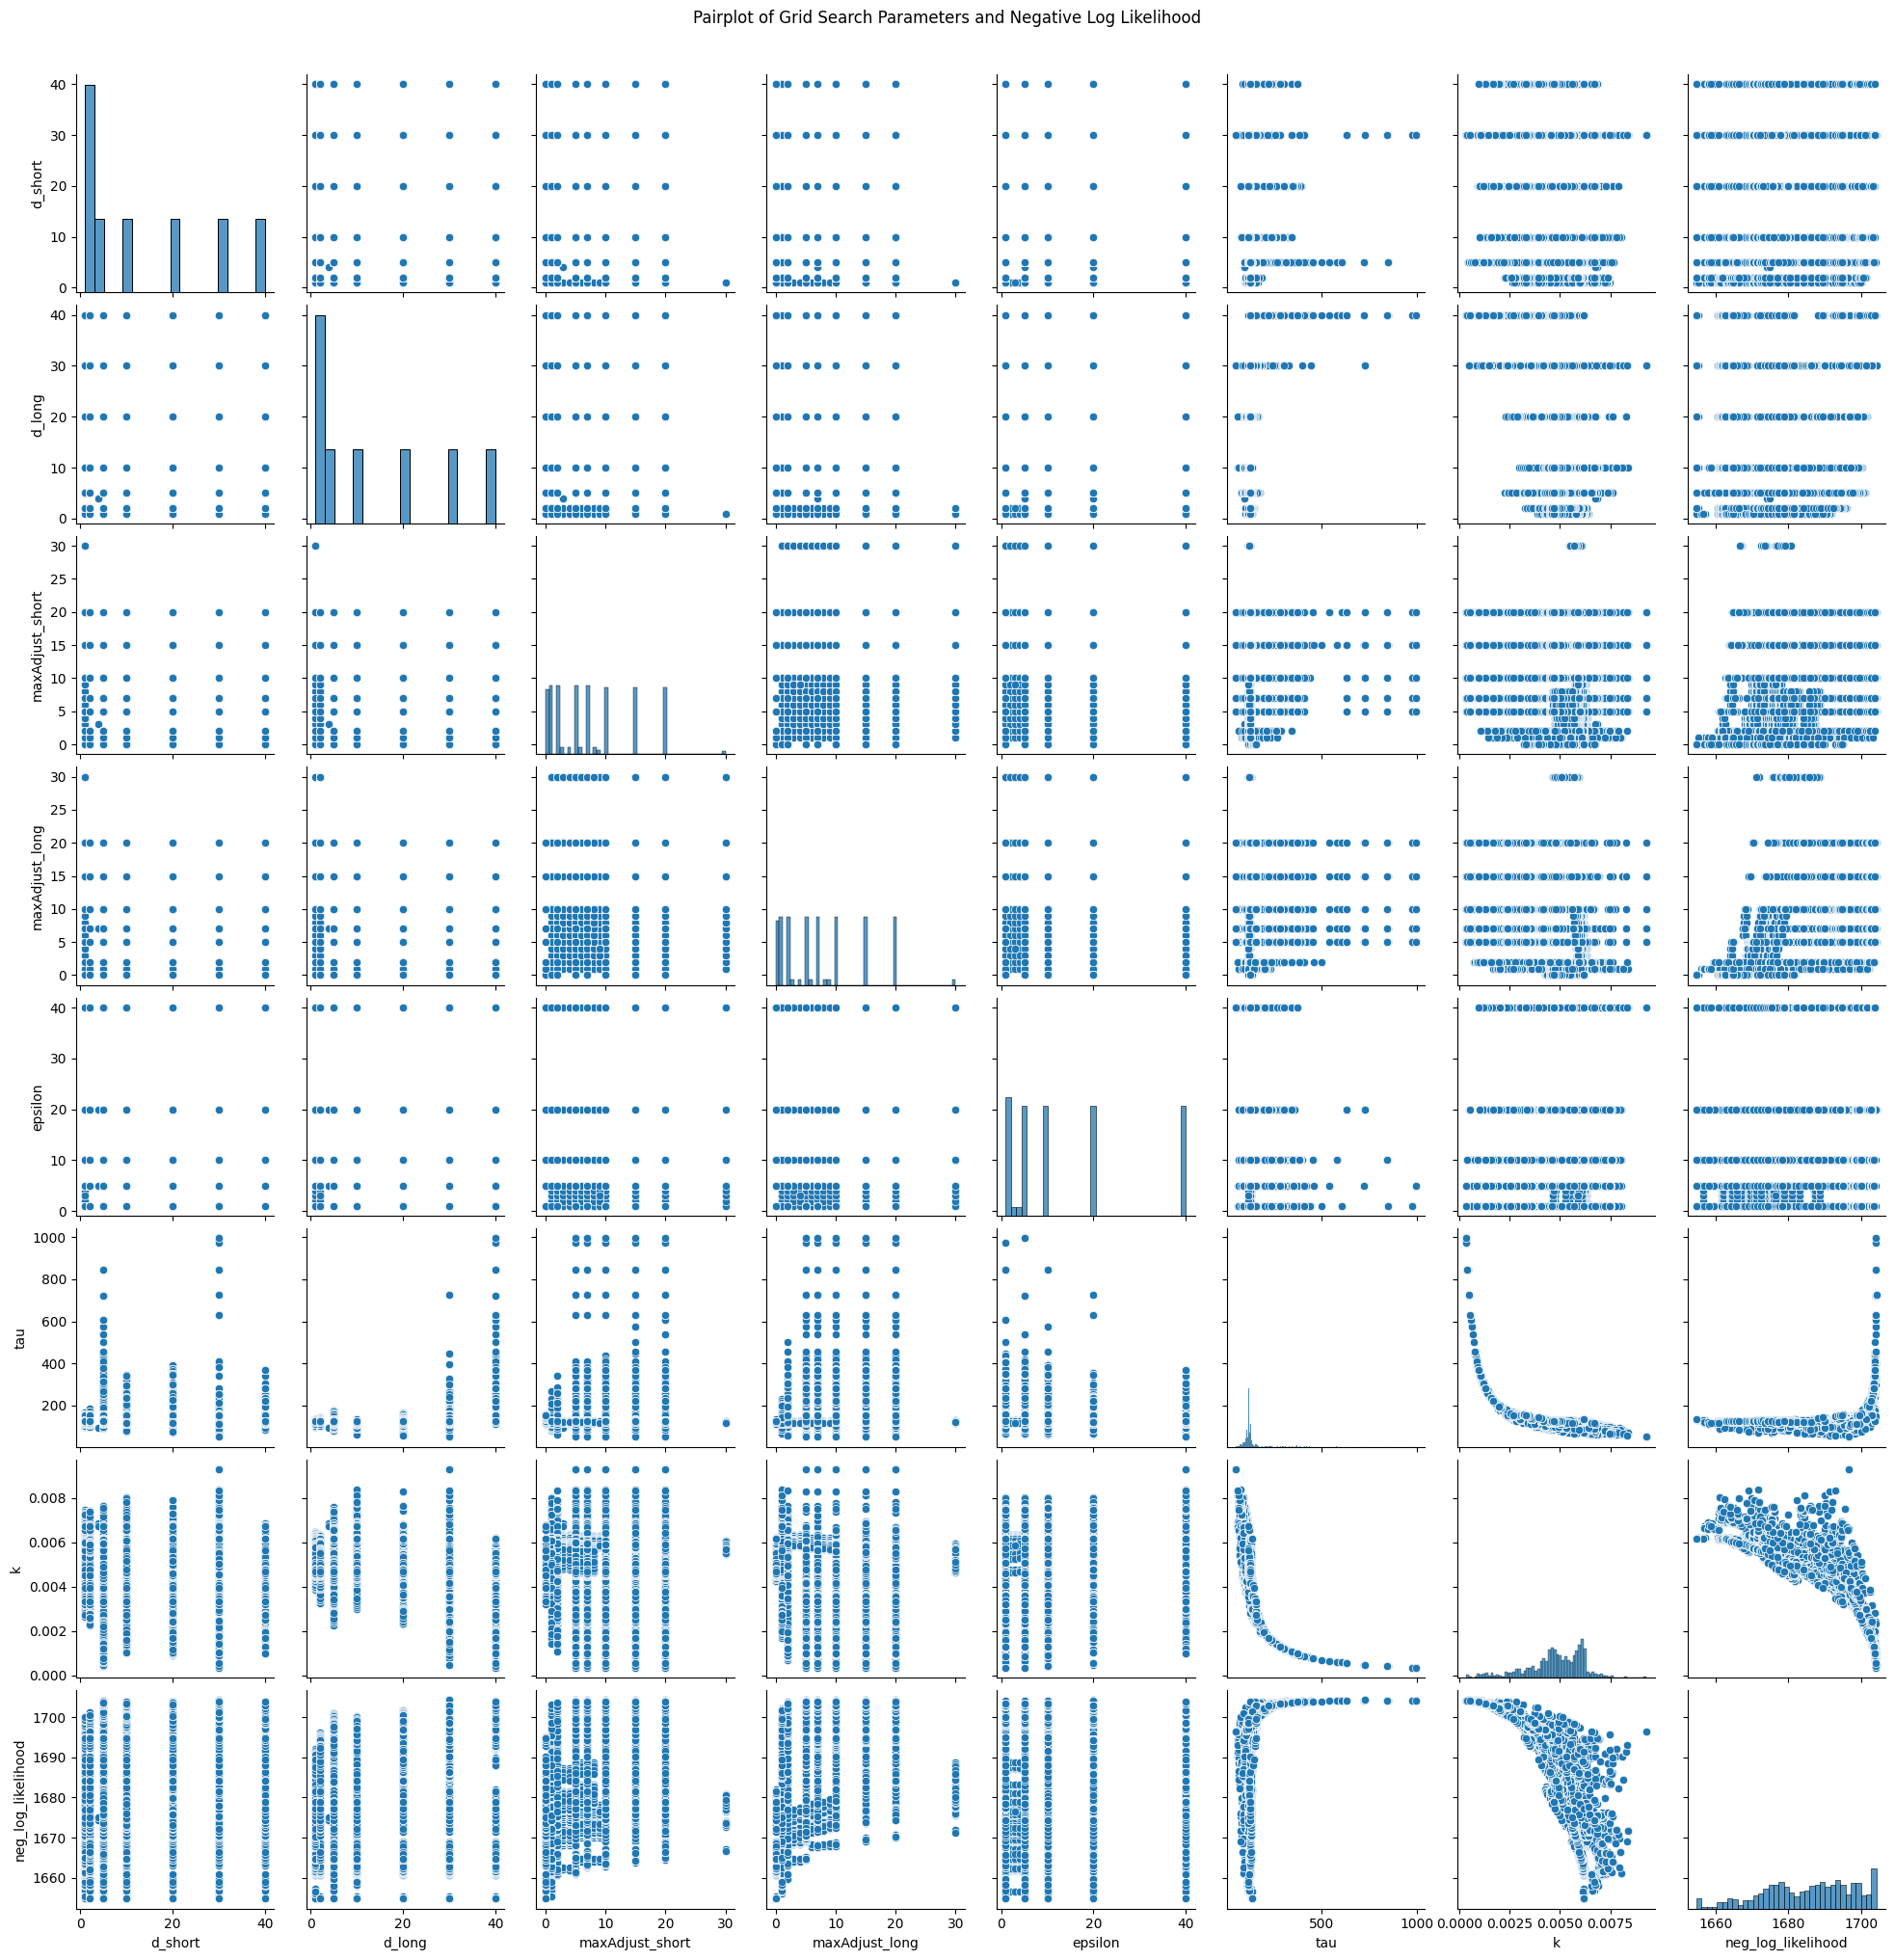

In [48]:
sns.pairplot(df_grid)
plt.suptitle("Pairplot of Grid Search Parameters and Negative Log Likelihood", y=1.02)
plt.show()

2025-04-08 07:23:57,177 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x30a1d9130>


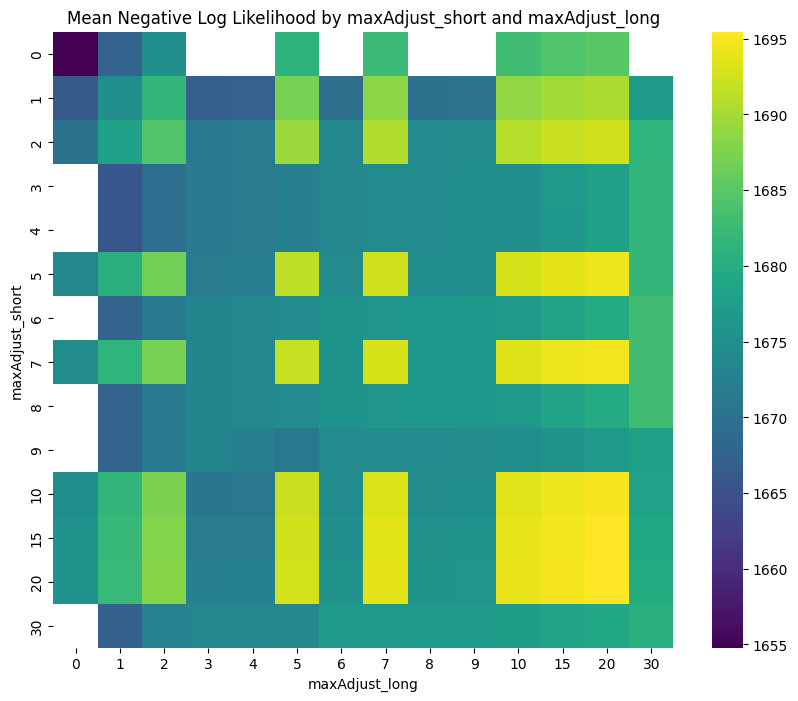

In [55]:
# For example, let’s create a pivot table of mean neg_log_likelihood with tau on one axis and k on the other.
heatmap_data = df_grid.pivot_table(index='maxAdjust_short', columns='maxAdjust_long', values='neg_log_likelihood', aggfunc='mean')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=False, fmt=".1f", cmap="viridis")
plt.title("Mean Negative Log Likelihood by maxAdjust_short and maxAdjust_long")
plt.ylabel("maxAdjust_short")
plt.xlabel("maxAdjust_long")
plt.show()

### Plot model prediction vs actual data

####  By stimulus and conditions

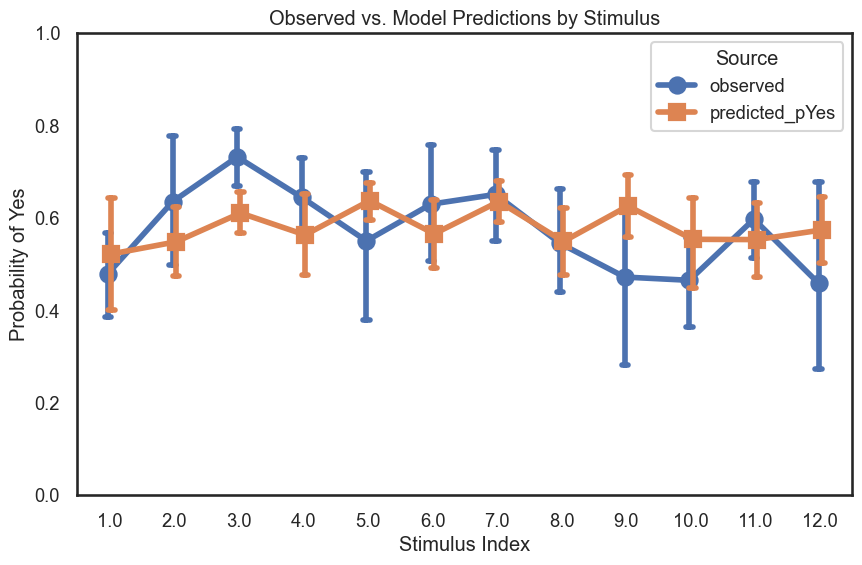

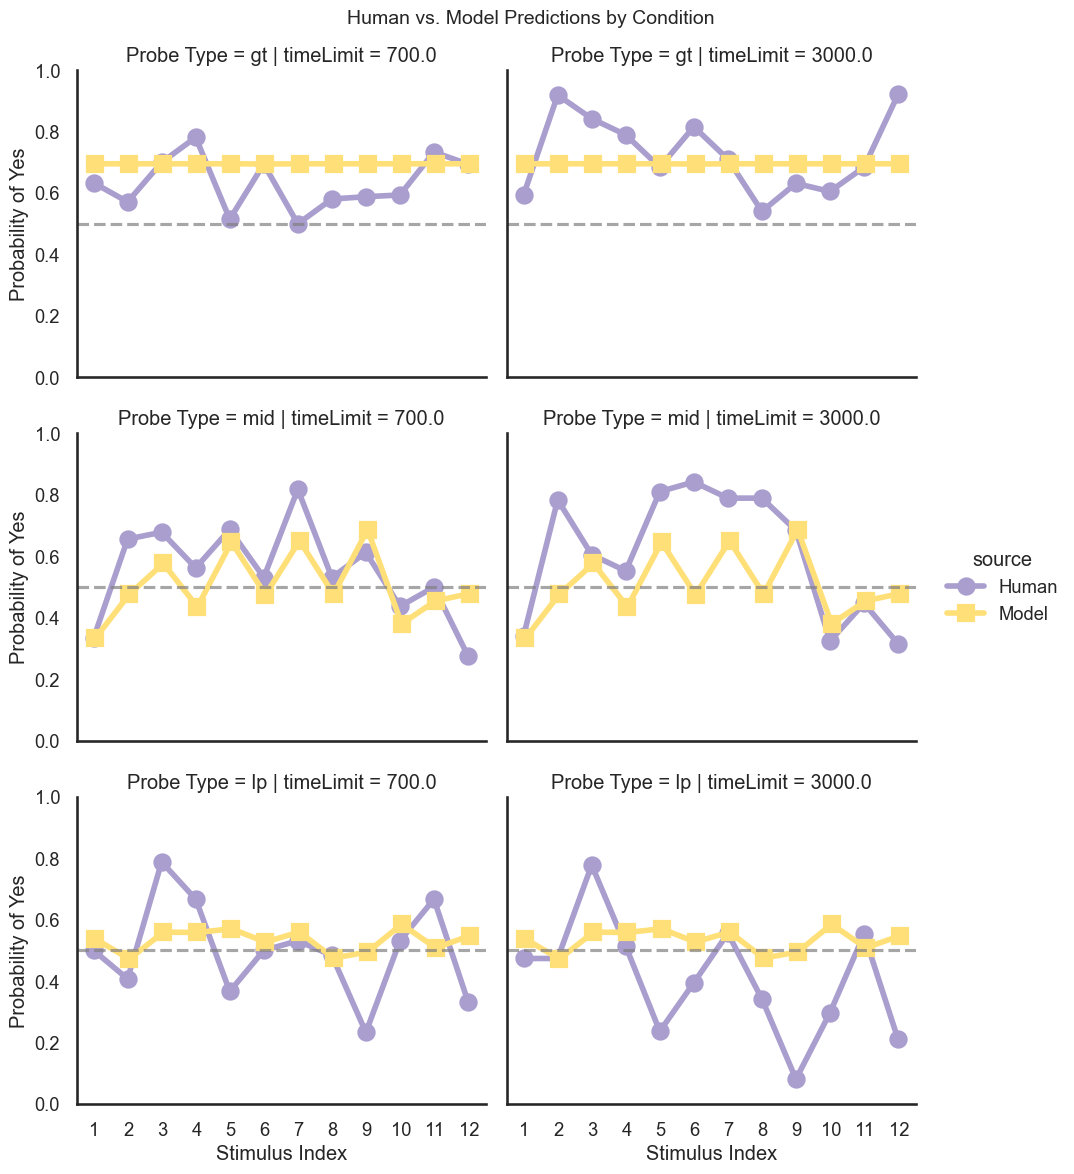

In [223]:

# 1. AGGREGATE OBSERVED DATA
# Assuming df_exp2 now has one row per trial, with 'response_num' = 1 or 0, 
# and columns: 'stimulus_idx', 'choice', 'timeLimit'.
# We'll compute the observed proportion of "Yes" in each group:
df_observed = df_exp2.groupby(['stimulus_idx', 'choice', 'timeLimit'], as_index=False)['response_num'].mean()
df_observed.rename(columns={'response_num': 'observed'}, inplace=True)
# Now df_observed has columns: stimulus_idx, choice, timeLimit, observed

# 2. AGGREGATE MODEL PREDICTIONS
# You mentioned you merged group_predictions back to df_exp2 as a 'predicted_pYes' column. 
# So each row has a predicted probability. We'll average them in the same grouping:
df_predicted = df_exp2.groupby(['stimulus_idx', 'choice', 'timeLimit'], as_index=False)['predicted_pYes'].mean()
# Now df_predicted has columns: stimulus_idx, choice, timeLimit, predicted_pYes

# 3. MERGE OBSERVED AND PREDICTED
df_merged = pd.merge(df_observed, df_predicted, on=['stimulus_idx', 'choice', 'timeLimit'], how='inner')
# Now df_merged has columns: stimulus_idx, choice, timeLimit, observed, predicted_pYes

# 4. MELT INTO LONG FORMAT
df_long = df_merged.melt(
    id_vars=['stimulus_idx', 'choice', 'timeLimit'],
    value_vars=['observed', 'predicted_pYes'],
    var_name='source',         # e.g. "observed" vs "predicted_pYes"
    value_name='pYes'          # the numeric probability/ proportion
)
# Now df_long has columns: stimulus_idx, choice, timeLimit, source, pYes
# where source is either "observed" or "predicted_pYes"

# 5. PLOT BOTH LINES ON THE SAME FIGURE
plt.figure(figsize=(10, 6))
sns.pointplot(x='stimulus_idx', y='pYes', hue='source', data=df_long,
              dodge=True, markers=['o', 's'], capsize=.1)
plt.title("Observed vs. Model Predictions by Stimulus")
plt.xlabel("Stimulus Index")
plt.ylabel("Probability of Yes")
plt.ylim(0, 1)  # optional, ensures y-axis goes 0 to 1
plt.legend(title="Source")
plt.show()


# Rename keys for clarity:
#   'choice' -> 'Probe Type'
#   'observed_prediction' to 'Participant' and 'model_prediction' to 'Model'
df_long = df_long.rename(columns={'choice': 'Probe Type'})

# Ensure stimulus_idx is an integer.
df_long['stimulus_idx'] = df_long['stimulus_idx'].astype(int)

df_long['source'] = df_long['source'].replace({
    'observed': 'Human',
    'predicted_pYes': 'Model'
})

# Optionally, sort the DataFrame for clearer plotting.
df_long = df_long.sort_values(by=['stimulus_idx', 'Probe Type', 'timeLimit'])

# Define a custom palette (feel free to change to your preferred hex codes).
# custom_palette = {"Human": "#69A3EC",          # a nice blue
#                   "Model": "#F3C4C4"}          # a pleasant orange
custom_palette = {"Human": "#A99ECE",          # "#69A3EC" a nice blue
                  "Model": "#FFE078"}          # a pleasant orange

sns.set_context("talk", font_scale=0.8) 
# Create a faceted plot using catplot.
g = sns.catplot(
    data=df_long,
    x="stimulus_idx",
    y="pYes",
    hue="source",
    col="timeLimit",
    row="Probe Type",
    kind="point",
    dodge=True,
    markers=['o', 's'],
    palette=custom_palette,
    capsize=0.1,
    height=4,
    aspect=1.2
)

# Set axis labels and limits.
g.set_axis_labels("Stimulus Index", "Probability of Yes")
g.set(ylim=(0, 1))
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Human vs. Model Predictions by Condition", fontsize=14)

# Add a horizontal dashed line at p = 0.5 in each subplot.
g.map(plt.axhline, y=0.5, color='gray', linestyle='--', alpha=0.7)

plt.show()

#### Accuracy

In [118]:
# Assume df_exp2 is your DataFrame after running process_file for all participants
# and merging the model's 'predicted_pYes' column onto it.
# It should contain: 'choice', 'predicted_pYes', and the human 'is_accurate'.

# Define the threshold for converting model probability to a binary choice
model_threshold = 0.5

# Determine the model's predicted response ('j' or 'f')
df_exp2['model_predicted_response'] = np.where(df_exp2['predicted_pYes'] > model_threshold, 'j', 'f')

# Apply the same accuracy logic to the model's predicted response
def calculate_model_accuracy(row):
  """Applies the accuracy logic based on model's predicted response."""
  model_resp = row['model_predicted_response']
  choice_type = row['choice']

  if model_resp == 'j' and choice_type == 'gt':
    return True
  elif model_resp == 'f' and choice_type in ['lp', 'mid']:
    return True
  else:
    # Assuming model always provides a prediction, so no NA case needed unless pYes is NA
    return False

# Apply the function row-wise - Note: Can be slow for very large dataframes
# Consider vectorization if performance is critical
df_exp2['is_accurate_model'] = df_exp2.apply(calculate_model_accuracy, axis=1)

# Optional: Convert to boolean type if needed (keeps True/False)
# df_exp2['is_accurate_model'] = df_exp2['is_accurate_model'].astype('boolean')

print("Added 'model_predicted_response' and 'is_accurate_model' columns.")
print(df_exp2[['choice', 'predicted_pYes', 'model_predicted_response', 'is_accurate', 'is_accurate_model']].head())

Added 'model_predicted_response' and 'is_accurate_model' columns.
  choice  predicted_pYes model_predicted_response  is_accurate  \
0    mid        0.455491                        f        False   
1    mid        0.455491                        f        False   
2    mid        0.455491                        f         True   
3    mid        0.455491                        f         True   
4    mid        0.455491                        f        False   

   is_accurate_model  
0               True  
1               True  
2               True  
3               True  
4               True  


In [184]:
# --- Updated Data Preparation for Accuracy Plots ---

# Ensure boolean columns are treated as numeric (True=1, False=0) for mean calculation
# If they are already bool/boolean, .mean() works directly. If object, convert.
if df_exp2['is_accurate'].dtype == 'object':
     df_exp2['is_accurate'] = df_exp2['is_accurate'].astype(float) # Convert NA to NaN, True to 1.0, False to 0.0
if df_exp2['is_accurate_model'].dtype == 'object':
     df_exp2['is_accurate_model'] = df_exp2['is_accurate_model'].astype(float)

# Calculate Human Accuracy (Mean of is_accurate, ignoring NAs)
df_human_acc = df_exp2.groupby(['choice', 'timeLimit'], as_index=False)['is_accurate'].mean()
df_human_acc['source'] = 'Human'
df_human_acc.rename(columns={'is_accurate': 'Accuracy'}, inplace=True)

# Calculate Model Accuracy (Mean of is_accurate_model)
df_model_acc = df_exp2.groupby(['choice', 'timeLimit'], as_index=False)['is_accurate_model'].mean()
df_model_acc['source'] = 'Model'
df_model_acc.rename(columns={'is_accurate_model': 'Accuracy'}, inplace=True)

# Calculate Overall Accuracies
overall_human_acc = df_exp2['is_accurate'].mean()
overall_model_acc = df_exp2['is_accurate_model'].mean()

df_overall_acc = pd.DataFrame({
    'source': ['Human', 'Model'],
    'Accuracy': [overall_human_acc, overall_model_acc]
})

# Combine aggregated accuracy data for plotting by condition
df_acc_combined = pd.concat([df_human_acc, df_model_acc], ignore_index=True)

# Use the same palette and orders defined before
custom_palette = {"Human": "#A99ECE",          # "#69A3EC" a nice blue
                  "Model": "#FFE078"}          # a pleasant orange
choice_order = ["gt", "mid", "lp"]
time_limit_order = sorted(df_exp2['timeLimit'].unique())

print("--- Aggregated Accuracy Data for Plotting ---")
print("Overall Accuracies:")
print(df_overall_acc)
print("\nAccuracies by Condition:")
print(df_acc_combined)
print("-" * 30)

--- Aggregated Accuracy Data for Plotting ---
Overall Accuracies:
  source  Accuracy
0  Human  0.550040
1  Model  0.638911

Accuracies by Condition:
   choice  timeLimit  Accuracy source
0      gt      700.0  0.633075  Human
1      gt     3000.0  0.728477  Human
2     mid      700.0  0.445623  Human
3     mid     3000.0  0.392936  Human
4      lp      700.0  0.493404  Human
5      lp     3000.0  0.592428  Human
6      gt      700.0  1.000000  Model
7      gt     3000.0  1.000000  Model
8     mid      700.0  0.671088  Model
9     mid     3000.0  0.666667  Model
10     lp      700.0  0.232190  Model
11     lp     3000.0  0.251670  Model
------------------------------


In [236]:
df_exp2['model_predicted_response'] = np.where(df_exp2['predicted_pYes'] > 0.5, 'j', 'f')

df_exp2.groupby('timeLimit')['model_predicted_response'].value_counts(normalize=True)

timeLimit  model_predicted_response
700.0      j                           0.701662
           f                           0.298338
3000.0     j                           0.693727
           f                           0.306273
Name: model_predicted_response, dtype: float64

##### Overall accuracy

/var/folders/sb/gb2znhb5759b8kyb5sbpjx180000gn/T/ipykernel_69856/676254867.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_overall_acc, x='source', y='Accuracy', palette=custom_palette)


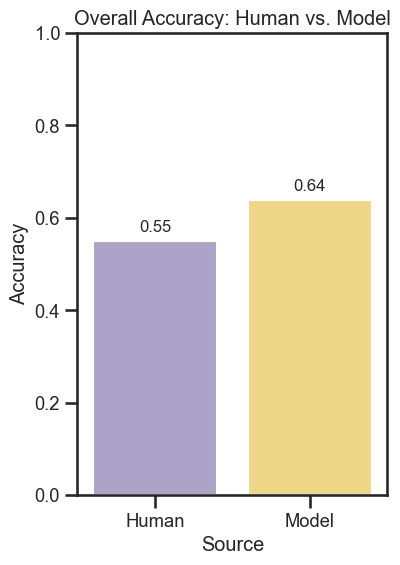

In [185]:
# Use your custom palette for consistency.

# Plot overall accuracy.
plt.figure(figsize=(4,6))
sns.barplot(data=df_overall_acc, x='source', y='Accuracy', palette=custom_palette)
plt.ylim(0, 1)
plt.title('Overall Accuracy: Human vs. Model')
plt.xlabel('Source')
plt.ylabel('Accuracy')
# Optionally annotate the bars with the accuracy values.
for idx, row in df_overall_acc.iterrows():
    plt.text(idx, row['Accuracy'] + 0.02, f"{row['Accuracy']:.2f}", ha='center', fontsize=12)
plt.show()

##### Accuracy by probe type

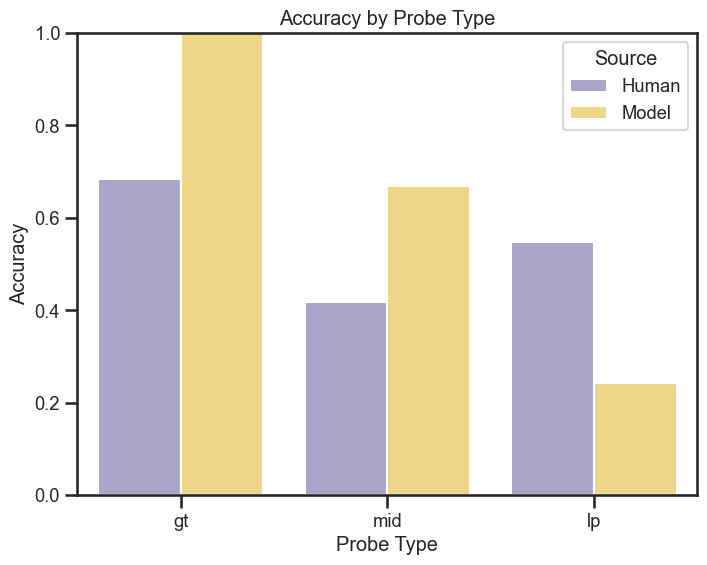

In [172]:
# Aggregate accuracy by probe type ignoring time limits.
df_acc_by_choice = df_exp2.groupby('choice', as_index=False).agg(
    human_accuracy=('is_accurate', 'mean'),
    model_accuracy=('is_accurate_model', 'mean')
)

# Reshape the data for plotting.
df_acc_by_choice = pd.melt(
    df_acc_by_choice,
    id_vars=['choice'],
    value_vars=['human_accuracy', 'model_accuracy'],
    var_name='source',
    value_name='Accuracy'
)
df_acc_by_choice['source'] = df_acc_by_choice['source'].replace({
    'human_accuracy': 'Human',
    'model_accuracy': 'Model'
})

# Optional: If you have a preferred order for choices.
choice_order = ["gt", "mid", "lp"]

plt.figure(figsize=(8,6))
sns.barplot(
    data=df_acc_by_choice,
    x='choice',
    y='Accuracy',
    hue='source',
    palette=custom_palette,
    order=choice_order
)
plt.ylim(0, 1)
plt.title("Accuracy by Probe Type")
plt.xlabel("Probe Type")
plt.ylabel("Accuracy")
plt.legend(title="Source")
plt.show()

##### Accuracy by time limit

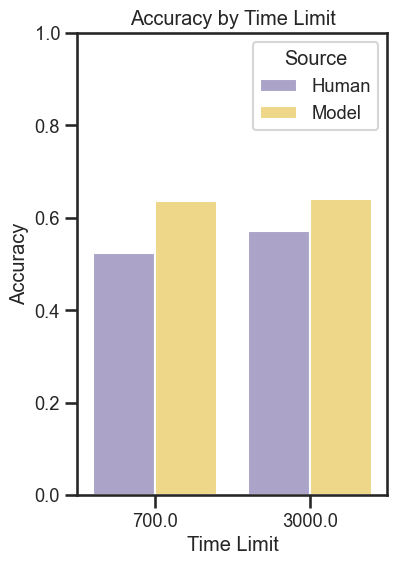

In [174]:
# Aggregate accuracy by time limit ignoring probe types.
df_acc_by_time = df_exp2.groupby('timeLimit', as_index=False).agg(
    human_accuracy=('is_accurate', 'mean'),
    model_accuracy=('is_accurate_model', 'mean')
)

# Reshape the data for plotting.
df_acc_by_time = pd.melt(
    df_acc_by_time,
    id_vars=['timeLimit'],
    value_vars=['human_accuracy', 'model_accuracy'],
    var_name='source',
    value_name='Accuracy'
)
df_acc_by_time['source'] = df_acc_by_time['source'].replace({
    'human_accuracy': 'Human',
    'model_accuracy': 'Model'
})

# Order time limits if needed.
time_limit_order = sorted(df_exp2['timeLimit'].unique())

plt.figure(figsize=(4,6))
sns.barplot(
    data=df_acc_by_time,
    x='timeLimit',
    y='Accuracy',
    hue='source',
    palette=custom_palette,
    order=time_limit_order
)
plt.ylim(0, 1)
plt.title("Accuracy by Time Limit")
plt.xlabel("Time Limit")
plt.ylabel("Accuracy")
plt.legend(title="Source")
plt.show()

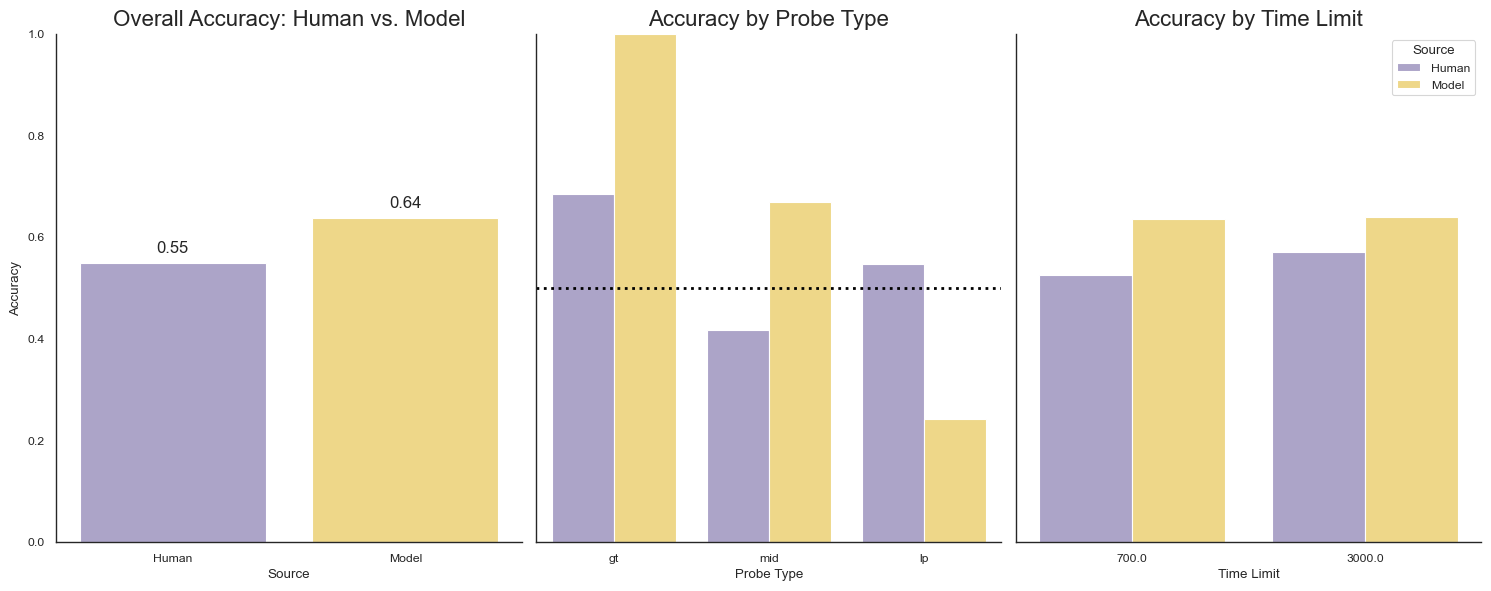

In [271]:
# Suppose your DataFrames and ordering variables are defined:
# df_overall_acc, df_acc_by_choice, df_acc_by_time
# choice_order (e.g., ["gt", "mid", "lp"]) and 
# time_limit_order (e.g., sorted(df_exp2['timeLimit'].unique()))
sns.set_context("paper")
# Create a figure with three subplots in one row.
fig, axs = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
hue_order=["Human", "Model"]
# ------------------
# Plot 1: Overall Accuracy
# ------------------
sns.barplot(data=df_overall_acc, 
            x='source', 
            y='Accuracy', 
            hue='source', 
            palette=custom_palette,
            hue_order=hue_order, 
            dodge=False, 
            ax=axs[0])
axs[0].set_ylim(0, 1)
axs[0].set_title("Overall Accuracy: Human vs. Model", fontsize=16)
axs[0].set_xlabel("Source")
axs[0].set_ylabel("Accuracy")

# Annotate each bar with its accuracy value.
for idx, row in df_overall_acc.iterrows():
    axs[0].text(idx, row['Accuracy'] + 0.02, f"{row['Accuracy']:.2f}", 
                ha='center', fontsize=12)

# Remove the subplot legend because we'll add a common legend later.
if axs[0].get_legend():
    axs[0].legend_.remove()

# ------------------
# Plot 2: Accuracy by Probe Type
# ------------------
sns.barplot(data=df_acc_by_choice, 
            x='choice', 
            y='Accuracy', 
            hue='source', 
            palette=custom_palette, 
            hue_order=hue_order,
            ax=axs[1], 
            order=choice_order)
axs[1].set_ylim(0, 1)
axs[1].set_title("Accuracy by Probe Type", fontsize=16)
axs[1].set_xlabel("Probe Type")
axs[1].set_ylabel("Accuracy")
if axs[1].get_legend():
    axs[1].legend_.remove()
axs[1].axhline(y=0.5, linewidth=2, color='black', ls=':')

# ------------------
# Plot 3: Accuracy by Time Limit
# ------------------
sns.barplot(data=df_acc_by_time, 
            x='timeLimit', 
            y='Accuracy', 
            hue='source', 
            palette=custom_palette, 
            hue_order=hue_order,
            ax=axs[2], 
            order=time_limit_order)
axs[2].set_ylim(0, 1)
axs[2].set_title("Accuracy by Time Limit", fontsize=16)
axs[2].set_xlabel("Time Limit")
axs[2].set_ylabel("Accuracy")
axs[2].legend(handles, labels, loc="upper right", ncol=1, title="Source")
# if axs[2].get_legend():
#     axs[2].legend_.remove()

# ------------------
# Add a global legend
# ------------------
# Retrieve legend handles and labels from one of the plots; here we use the second subplot.
# handles, labels = axs[1].get_legend_handles_labels()
# fig.legend(handles, labels, loc="lower center", ncol=2, title="Source")

# Set an overall title for the figure.
# fig.suptitle("Comparison of Human vs. Model Accuracy", fontsize=16, y=1.05)
# Adjust spacing for the figure.
plt.subplots_adjust(top=0.88, wspace=0.3)

# Despine for a cleaner look.
sns.despine(fig=fig, top=True, right=True)
plt.tight_layout()
plt.show()

#### Responses

In [242]:
# 1) Human DataFrame
df_human = df_exp2[['stimulus_idx', 'choice', 'timeLimit', 'response']].copy()
df_human = df_human.rename(columns={'response': 'response'})
df_human['source'] = 'Human'

# 2) Model DataFrame
df_model = df_exp2[['stimulus_idx', 'choice', 'timeLimit', 'model_predicted_response']].copy()
df_model = df_model.rename(columns={'model_predicted_response': 'response'})
df_model['source'] = 'Model'

# 3) Combine
df_combined = pd.concat([df_human, df_model], ignore_index=True)

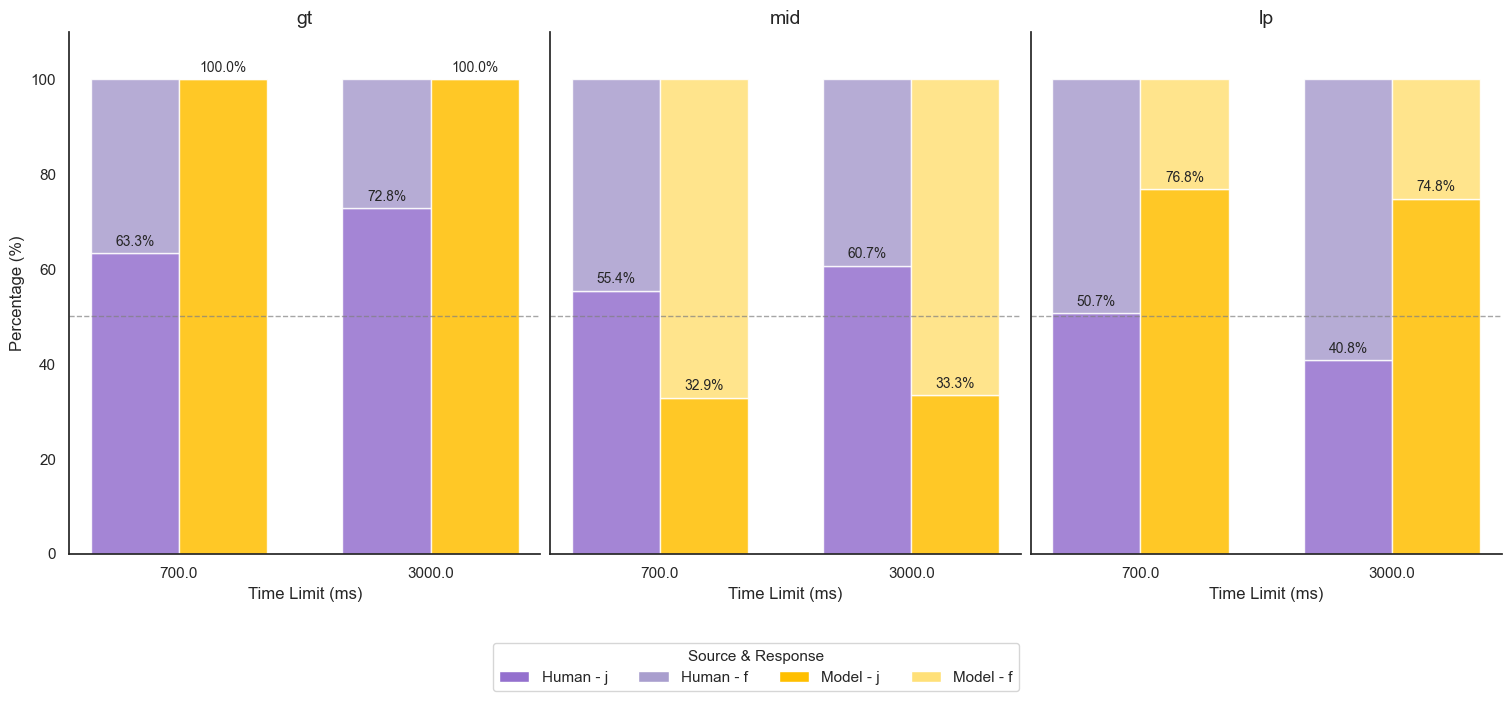

In [269]:
### if calculate model prediction with considerations of the  uneven missingness across time limits
### then model aggregated responses vary slightly across time limits here

sns.set_theme(style="white")
# --- Original Custom Palette ---
custom_palette = {"Human": "#A99ECE", "Model": "#FFE078"}

# --- Derived color scheme for responses ---
# For Human: use a darker shade for 'j' and the original for 'f'
HUMAN_J = "#9470CE"   # Darker shade for 'j'
HUMAN_F = custom_palette["Human"]  # Use the original for 'f'

# For Model: use a darker shade for 'j' and the original for 'f'
MODEL_J = "#FFBF00"   # Darker shade for 'j'
MODEL_F = custom_palette["Model"]  # Use the original for 'f'

# Create a mapping for easier lookup:
color_map = {
    ("Human", "j"): HUMAN_J,
    ("Human", "f"): HUMAN_F,
    ("Model", "j"): MODEL_J,
    ("Model", "f"): MODEL_F
}


# --- Define your ordered probe types.
choice_order = ["gt", "mid", "lp"]

def plot_clustered_stacked_bar(data):
    
    # Drop rows with missing responses
    data = data.dropna(subset=['response']).copy()
    
    # Enforce categorical ordering if needed
    data['choice'] = pd.Categorical(data['choice'], categories=choice_order, ordered=True)
    
    # Group by choice, timeLimit, source, and response, and count occurrences.
    grouped_data = (data.groupby(['choice', 'timeLimit', 'source', 'response'])
                    .size()
                    .reset_index(name='count'))
    
    # Compute total count and percentage within each (choice, timeLimit, source) grouping.
    grouped_data['total'] = grouped_data.groupby(['choice', 'timeLimit', 'source'])['count'].transform('sum')
    grouped_data['percentage'] = 100 * grouped_data['count'] / grouped_data['total']
    
    # Create subplots: one per probe type.
    choices = choice_order  # use the predefined order.
    n_choices = len(choices)
    fig, axs = plt.subplots(1, n_choices, figsize=(n_choices * 5, 6), sharey=True, constrained_layout=True)
    if n_choices == 1:
        axs = [axs]
    
    bar_width = 0.35  # Width for the individual (clustered) bars.
    
    for i, choice in enumerate(choices):
        ax = axs[i]
        subset = grouped_data[grouped_data['choice'] == choice]
        
        # Get sorted time limits for the x-axis.
        time_limits = sorted(subset['timeLimit'].unique())
        x_positions = range(len(time_limits))  # Base positions.
        
        for j, tl in enumerate(time_limits):
            # For each timeLimit, plot two bars: Human (left offset) and Model (right offset).
            for src in ["Human", "Model"]:
                offset = -bar_width/2 if src == "Human" else bar_width/2
                x_loc = j + offset

                # Filter for this timeLimit and source.
                grp = subset[(subset['timeLimit'] == tl) & (subset['source'] == src)]
                
                # Get the percentages for response 'j' and 'f' (or 0 if missing).
                perc_j = float(grp.loc[grp['response'] == 'j', 'percentage']) if not grp.loc[grp['response'] == 'j'].empty else 0
                perc_f = float(grp.loc[grp['response'] == 'f', 'percentage']) if not grp.loc[grp['response'] == 'f'].empty else 0

                # Plot the stacked segments: first the 'j' response, then stack 'f' on top.
                bottom = 0
                ax.bar(x_loc, perc_j, width=bar_width, bottom=bottom,
                       color=color_map[(src, 'j')], alpha=0.85)
                bottom += perc_j
                ax.bar(x_loc, perc_f, width=bar_width, bottom=bottom,
                       color=color_map[(src, 'f')], alpha=0.85)

                # Annotate with the perc_j on top.
                total_perc = perc_j + perc_f
                ax.text(x_loc, bottom + 1, f"{perc_j:.1f}%", ha='center', va='bottom', fontsize=10)
        
        # Set axes labels, title, and styling for each subplot.
        ax.set_title(f"{choice}", fontsize=14)
        ax.set_xticks(list(x_positions))
        ax.set_xticklabels([str(tl) for tl in time_limits], fontsize=11)
        if i == 0:
            ax.set_ylabel("Percentage (%)", fontsize=12)
        else:
            ax.set_ylabel("")
        ax.set_xlabel("Time Limit (ms)", fontsize=12)
        ax.axhline(y=50, color='gray', linestyle='--', linewidth=1, alpha=0.7)
        ax.set_ylim(0, 110)
        ax.tick_params(axis='x', rotation=0)
    
    # --- Create a unified legend ---
    # Build legend elements for each (source, response) combination.
    legend_elements = [
        patches.Patch(facecolor=HUMAN_J, label="Human - j"),
        patches.Patch(facecolor=HUMAN_F, label="Human - f"),
        patches.Patch(facecolor=MODEL_J, label="Model - j"),
        patches.Patch(facecolor=MODEL_F, label="Model - f"),
    ]
    
    # Create legend using keyword for 'handles' explicitly.
    leg = fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05),
               ncol=4)
    leg.set_title("Source & Response")
    leg.get_title().set_fontsize(11)
    for text in leg.get_texts():
        text.set_fontsize(11)
    
    # fig.suptitle("Stacked Response Proportions: Human vs. Model", fontsize=18, y=1.02)
    sns.despine(fig=fig, top=True, right=True)
    # plt.tight_layout()
    # plt.subplots_adjust(bottom=0.15)
    plt.show()

# --- Usage ---
# Assuming your combined DataFrame with columns [choice, timeLimit, response, source] is named df_combined:
plot_clustered_stacked_bar(df_combined)

/var/folders/sb/gb2znhb5759b8kyb5sbpjx180000gn/T/ipykernel_69856/3431044727.py:136: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


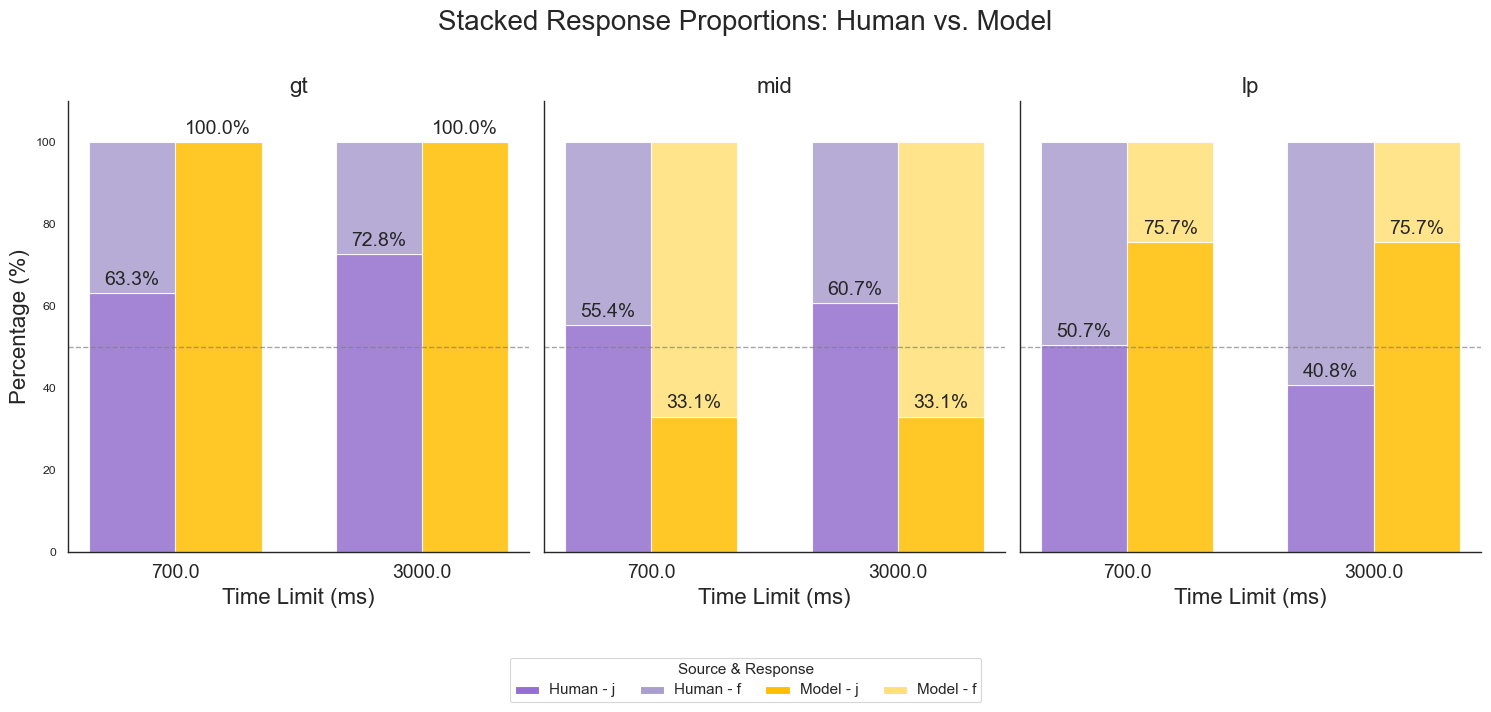

In [272]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.patches import Patch
import matplotlib.patches as patches

# --- Original Custom Palette ---
custom_palette = {"Human": "#A99ECE", "Model": "#FFE078"}

# --- Derived color scheme for responses ---
# For Human: use a darker shade for 'j' and the original for 'f'
HUMAN_J = "#9470CE"   # Darker shade for 'j'
HUMAN_F = custom_palette["Human"]  # Use the original for 'f'

# For Model: use a darker shade for 'j' and the original for 'f'
MODEL_J = "#FFBF00"   # Darker shade for 'j'
MODEL_F = custom_palette["Model"]  # Use the original for 'f'

# Create a mapping for easier lookup:
color_map = {
    ("Human", "j"): HUMAN_J,
    ("Human", "f"): HUMAN_F,
    ("Model", "j"): MODEL_J,
    ("Model", "f"): MODEL_F
}

# --- Define your ordered probe types.
choice_order = ["gt", "mid", "lp"]

def plot_clustered_stacked_bar(data):
    # Drop rows with missing responses.
    data = data.dropna(subset=['response']).copy()
    
    # Enforce categorical ordering for 'choice'.
    data['choice'] = pd.Categorical(data['choice'], categories=choice_order, ordered=True)
    
    # Group by choice, timeLimit, source, and response, and count occurrences.
    grouped_data = (data.groupby(['choice', 'timeLimit', 'source', 'response'])
                    .size()
                    .reset_index(name='count'))
    
    # Compute total count and percentage within each (choice, timeLimit, source) grouping.
    grouped_data['total'] = grouped_data.groupby(['choice', 'timeLimit', 'source'])['count'].transform('sum')
    grouped_data['percentage'] = 100 * grouped_data['count'] / grouped_data['total']
    
    # ----- Recompute Model Predictions Over All Time Limits -----
    # For rows where source=="Model", we ignore timeLimit. For each (choice, response),
    # sum up counts to get overall percentages.
    model_data = grouped_data[grouped_data['source'] == 'Model'].copy()
    model_overall = model_data.groupby(['choice', 'response'], as_index=False)['count'].sum()
    model_overall['total'] = model_overall.groupby('choice')['count'].transform('sum')
    model_overall['percentage'] = 100 * model_overall['count'] / model_overall['total']
    # Now, for every row in grouped_data with source "Model",
    # override the 'percentage' with the aggregated value from model_overall (by matching on 'choice' and 'response').
    def get_model_percentage(row):
        choice_val = row['choice']
        response_val = row['response']
        val = model_overall.loc[(model_overall['choice'] == choice_val) &
                                (model_overall['response'] == response_val), 'percentage']
        if not val.empty:
            return float(val)
        else:
            return 0
    mask_model = grouped_data['source'] == 'Model'
    grouped_data.loc[mask_model, 'percentage'] = grouped_data[mask_model].apply(get_model_percentage, axis=1)
    # ----- End of Model Percentage Recalculation -----
    
    # Create subplots: one per probe type.
    n_choices = len(choice_order)
    fig, axs = plt.subplots(1, n_choices, figsize=(n_choices * 5, 6), sharey=True, constrained_layout=True)
    if n_choices == 1:
        axs = [axs]
    
    bar_width = 0.35  # Width for the individual (clustered) bars.
    
    for i, choice in enumerate(choice_order):
        ax = axs[i]
        subset = grouped_data[grouped_data['choice'] == choice]
        
        # Get sorted time limits for the x-axis.
        time_limits = sorted(subset['timeLimit'].unique())
        x_positions = list(range(len(time_limits)))  # Base positions.
        
        for j, tl in enumerate(time_limits):
            # For each timeLimit, plot two bars: Human (left offset) and Model (right offset).
            for src in ["Human", "Model"]:
                offset = -bar_width/2 if src == "Human" else bar_width/2
                x_loc = j + offset

                # Filter for this timeLimit and source.
                grp = subset[(subset['timeLimit'] == tl) & (subset['source'] == src)]
                
                # Get the percentages for response 'j' and 'f' (or 0 if missing).
                perc_j = float(grp.loc[grp['response'] == 'j', 'percentage']) if not grp.loc[grp['response'] == 'j'].empty else 0
                perc_f = float(grp.loc[grp['response'] == 'f', 'percentage']) if not grp.loc[grp['response'] == 'f'].empty else 0

                # Plot the stacked segments: first the 'j' response, then stack 'f' on top.
                bottom = 0
                ax.bar(x_loc, perc_j, width=bar_width, bottom=bottom,
                       color=color_map[(src, 'j')], alpha=0.85)
                bottom += perc_j
                ax.bar(x_loc, perc_f, width=bar_width, bottom=bottom,
                       color=color_map[(src, 'f')], alpha=0.85)

                # Annotate with the 'j' percentage on top.
                ax.text(x_loc, bottom + 1, f"{perc_j:.1f}%", ha='center', va='bottom', fontsize=14)
        
        # Set axes labels, title, and styling for each subplot.
        ax.set_title(f"{choice}", fontsize=16)
        ax.set_xticks(x_positions)
        ax.set_xticklabels([str(tl) for tl in time_limits], fontsize=14)
        if i == 0:
            ax.set_ylabel("Percentage (%)", fontsize=16)
        else:
            ax.set_ylabel("")
        ax.set_xlabel("Time Limit (ms)", fontsize=16)
        ax.axhline(y=50, color='gray', linestyle='--', linewidth=1, alpha=0.7)
        ax.set_ylim(0, 110)
        ax.tick_params(axis='x', rotation=0)
    
    # --- Create a unified legend ---
    legend_elements = [
        patches.Patch(facecolor=HUMAN_J, label="Human - j"),
        patches.Patch(facecolor=HUMAN_F, label="Human - f"),
        patches.Patch(facecolor=MODEL_J, label="Model - j"),
        patches.Patch(facecolor=MODEL_F, label="Model - f"),
    ]
    leg = fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)
    leg.set_title("Source & Response")
    leg.get_title().set_fontsize(11)
    for text in leg.get_texts():
        text.set_fontsize(11)
    
    fig.suptitle("Stacked Response Proportions: Human vs. Model", fontsize=20, y=1.02)
    sns.despine(fig=fig, top=True, right=True)
    plt.tight_layout()
    # plt.subplots_adjust(bottom=0.15)
    plt.show()

# --- Usage ---
# Assuming your combined DataFrame has columns [choice, timeLimit, response, source]
# and is named df_combined, then:
plot_clustered_stacked_bar(df_combined)

## Previous code

## Defining the grid for free parameters

In [ ]:
# Usage of the function
positions = range(1, 13)  # Stimulus indices
anchors = range(1, 7)     # Obstacle indices
d_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]  # Displacement magnitudes
# Sam's rec: A shift of 20-40 pixels is pretty large, so it's not surprising that the optimal fit never chooses those values for d. 
# I think it probably makes sense to restrict the range to 1-10 and include more values within that range.
epsilon_values = [1, 5, 10, 20, 40]  # Tolerance levels # Exit Point
# epsilon_values = [10, 20, 40, 80, 100, 150, 200] # Path Sim
max_adjustments = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]  # Maximum adjustment steps

In [ ]:
def storeBestParams(best_setup, modelName):
    storeXYPrediction(best_setup['best_x'], best_setup['best_y'], modelName)

    with open(f'runSimulation/full72Trajectories/{modeling_choice}/{modelName}/adjustment_results.pkl', 'wb') as f:
        pickle.dump(best_setup, f)

def runEvalsFigs(modelName, df_all, n_free_params, withAdjust = False, best_setup = None):
    result_file_path = f'runSimulation/full72Trajectories/{modeling_choice}/{modelName}/all72_results.json'
    if not os.path.exists(result_file_path):
        runScript_72Simulations(f'runSimulation/full72Trajectories/{modeling_choice}/run72Simulations.py', modelName)
    with open(f'runSimulation/full72Trajectories/{modeling_choice}/{modelName}/adjustment_results.pkl', 'rb') as f:
        best_setup = pickle.load(f)
    getBICFromPrediction(best_setup['best_x'], best_setup['best_y'], df_all, n_free_params)
    compareFD_model_human(result_file_path, df_all, modelName)
    visualize72Trials(result_file_path, df_all, modelName, withAdjust, best_setup)
    # visualize72Trials(result_file_path, df_all)
    return best_setup

#### if compare with a random parameter set (for results checking & debugging)

In [ ]:
def debugResults(d, e, mxSteps, oneAnchorOrAll, x_init, y_init, modelInit, modelStop):
    debug_results = find_best_parameters(df_all, positions, oneAnchorOrAll, ball_Xs, x_blue_range, exitPoints_single,
                                            [d], [e], [mxSteps], x_init, y_init, modelInit, modelStop, True)
    return debug_results

## Mid + Sim_max

In [ ]:
modelName = 'Mid+Sim_max'
max_adjustments = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]
# max_adjustments = [np.infty]

# Initialize your x_init and y_init based on your specific needs
x_init = [[nearest_value_in_range(canvasWidth/2, x_blue_range[(stimulus_idx,obstacle_idx)][0],x_blue_range[(stimulus_idx,obstacle_idx)][1]) for obstacle_idx in anchors] for stimulus_idx in positions] #(1,1)(1,2)(1,3)...(1,6)(2,1)
y_init = [[nearest_value_in_range(canvasHeight/2, 150 + margin, 450 - margin) for obstacle_idx in anchors] for stimulus_idx in positions]


# Run the function
# Results will be the same across different anchors, so can just run one anchor
best_setup_mid_sim_max = find_best_parameters(df_all, positions, [1], ball_Xs, x_blue_range, exitPoints_single,
                                  d_values, epsilon_values, max_adjustments, x_init, y_init, 'Mid', 'exitPoint', False)

# Store the results
storeBestParams(best_setup_mid_sim_max, modelName)

In [ ]:
best_setup_mid_sim_max['best_n_steps']
#  'd': 4,
#  'epsilon': 5,
#  'maxSteps': 10,
#  'best_ml': -14799.718164780481,
#  [9, 6, 2, 1, 2, 4, 1, 5, 1, 10, 2, 10]

In [ ]:
best_setup_mid_sim_max = runEvalsFigs('Mid+Sim_max', df_all, 5)
print(best_setup_mid_sim_max['d'], best_setup_mid_sim_max['epsilon'], best_setup_mid_sim_max['maxSteps'])

In [ ]:
visualize72Trials(f'runSimulation/full72Trajectories/{modeling_choice}/{modelName}/all72_results.json', df_all, modelName, False, best_setup_mid_sim_max)

In [ ]:
# Test visualization
modelName = 'Mid+Sim_max'
x_init = [[nearest_value_in_range(canvasWidth/2, x_blue_range[(stimulus_idx,obstacle_idx)][0],x_blue_range[(stimulus_idx,obstacle_idx)][1]) for obstacle_idx in anchors] for stimulus_idx in positions] #(1,1)(1,2)(1,3)...(1,6)(2,1)
y_init = [[nearest_value_in_range(canvasHeight/2, 150 + margin, 450 - margin) for obstacle_idx in anchors] for stimulus_idx in positions]

simulation_scenario_test = SimulationScenario(
                            df_all, 2, 1, x_init, y_init,
                            ball_Xs, exitPoints_single, 'Mid', 'exitPoint', 15)
result = simulation_scenario_test.adjust_obstacle(1, 20)
simulation_scenario_test.visualize_adjustment_process(modelName)

In [ ]:
# generate adjustment gifs
modelName = 'Mid+Sim_max'
x_init = [[nearest_value_in_range(canvasWidth/2, x_blue_range[(stimulus_idx,obstacle_idx)][0],x_blue_range[(stimulus_idx,obstacle_idx)][1]) for obstacle_idx in anchors] for stimulus_idx in positions] #(1,1)(1,2)(1,3)...(1,6)(2,1)
y_init = [[nearest_value_in_range(canvasHeight/2, 150 + margin, 450 - margin) for obstacle_idx in anchors] for stimulus_idx in positions]

simulation_scenario_test = SimulationScenario(
                            df_all, 12, 2, x_init, y_init,
                            ball_Xs, x_blue_range, exitPoints_single, 'Mid', 'exitPoint', 10, True)
result = simulation_scenario_test.adjust_obstacle(4, 5)
simulation_scenario_test.visualize_adjustment_process(modelName)

In [ ]:
# check Results
modelName = 'Mid+Sim_max'
x_init = [[nearest_value_in_range(canvasWidth/2, x_blue_range[(stimulus_idx,obstacle_idx)][0],x_blue_range[(stimulus_idx,obstacle_idx)][1]) for obstacle_idx in anchors] for stimulus_idx in positions] #(1,1)(1,2)(1,3)...(1,6)(2,1)
y_init = [[nearest_value_in_range(canvasHeight/2, 150 + margin, 450 - margin) for obstacle_idx in anchors] for stimulus_idx in positions]
debugged_results = debugResults(4, 5, 10, [1], x_init, y_init, 'Mid', 'exitPoint')

In [ ]:
runEvalsFigs(modelName, df_all, 5, False, debugged_results)

## Visualizations with adjustment

In [ ]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.colorbar import ColorbarBase

# new function with legend
def visualize72Trials(jsonFilePath, df_all, modelName, withAdjust = False, best_setup = None):
    # Load JSON data, containing simulated trajectories from model prediction
    with open(jsonFilePath, 'r') as file:
        data = json.load(file)

    # Convert data to DataFrame
    df = pd.json_normalize(data)

    # Create a 12x6 grid of plots with shared axes and constrained layout
    fig, axes = plt.subplots(nrows=12, ncols=6, figsize=(30, 40), sharex=True, sharey=True, constrained_layout=True)

    # Loop through each row in the dataframe
    for idx, row in df.iterrows():
        stimulus_idx = row['stimulus_idx'] - 1  # 0-based index for matplotlib
        obstacle_idx = row['obstacle_idx'] - 1  # 0-based index

        ax = axes[stimulus_idx, obstacle_idx]
        ax.set_aspect('equal')
        
        if 'LP' in modelName:
            intersection = drawProjectedPath(row['stimulus_idx'], df_all, ax, 7)
        
        subset = drawInitialSetUp(ax, df_all, row['stimulus_idx'], row['obstacle_idx'])
        
        if withAdjust:
            # Find history for this specific condition
            history_idx = (row['stimulus_idx'] - 1) * 6 + (row['obstacle_idx'] - 1)
            history = best_setup['adjustment_histories'][history_idx]
            
            # Human Average FD
            human_fd = subset['fd_combined'].mean()
#             print(human_fd)
            
            fd_history = history['fd_history']
            
            # add before/after adjustment
            initial_x, initial_y = history['sol_history'][0][0],history['sol_history'][0][1]
            final_x, final_y = best_setup['best_x'][history_idx],best_setup['best_y'][history_idx]
            ax.text(0.95, 0.95, f'Initial: ({initial_x:.1f}, {initial_y:.1f})\nFinal: ({final_x:.1f}, {final_y:.1f})',
            verticalalignment='top', horizontalalignment='right',
            transform=ax.transAxes, color='dimgray', fontsize=8)
        
            # Calculate normalized differences and map to colors with controlled scaling
            fd_differences = np.abs(np.array(fd_history) - human_fd)
            if (fd_differences.max() - fd_differences.min()) != 0:
                normalized_differences = (fd_differences - fd_differences.min()) / (fd_differences.max() - fd_differences.min())
            else:
                # If all values are the same, set them to the middle of the scale (0.5 is arbitrary and can be adjusted)
                normalized_differences = np.full_like(fd_differences, fill_value=0.5)
#             normalized_differences = fd_differences / 100
    
#             print(row['stimulus_idx'], row['obstacle_idx'])
#             print(normalized_differences)
            # Define lower and upper bounds for the color scaling
            lower_bound = 0
            upper_bound = 0.6
            scaled_differences = lower_bound + (upper_bound - lower_bound) * normalized_differences
        
            colors = [plt.cm.YlOrBr(1 - diff) for diff in scaled_differences]  # The darker the color, the closer to fd_human_avg
            
            # Check if row['obstacle_X'] == best_setup['best_x'][history_idx]
            error = 0.00001
            if (abs(row['obstacle_X']-best_setup['best_x'][history_idx]) >= error) or (abs(row['obstacle_Y']-best_setup['best_y'][history_idx]) >= error):
#                 print(row['obstacle_X'], best_setup['best_x'][history_idx])
#                 print(row['obstacle_Y'], best_setup['best_y'][history_idx])
                raise Exception('Unmatched Data. Check history_index with df_all.')
                
            obstacle = patches.RegularPolygon((row['obstacle_X'], row['obstacle_Y']), numVertices=3, radius=45, orientation=np.pi, color=colors[-1], fill=True, alpha=0.7)
            ax.add_patch(obstacle)
            
            # Plot adjustment histories
            for i, step in enumerate(history['simulated_path_history']):
                step = np.array(step)
#                 alpha = i/len(history['simulated_path_history'])
                alpha = 1
                ax.plot(step[:, 0], step[:, 1], '-', alpha=alpha, zorder=7, color=colors[i], linewidth=1)  # Change color and alpha as needed
                
        else:
            # Add the model predicted obstacle position
            obstacle = patches.RegularPolygon((row['obstacle_X'], row['obstacle_Y']), numVertices=3, radius=45, orientation=np.pi, color=model_prediction_color, fill=True, alpha=0.7)
            ax.add_patch(obstacle)

            # Plot trajectory
            x_coords = [point[0] for point in row['simulated_trial']]
            y_coords = [point[1] for point in row['simulated_trial']]
            ax.plot(x_coords, y_coords, '-', linewidth=1.5, color='darkblue', label='Trajectory', zorder=6)

        ax.set_xlim(100, 900)
        ax.set_ylim(60, 540)
        ax.invert_yaxis()
        ax.set_title(f'Stimulus {row["stimulus_idx"]}, Obstacle {row["obstacle_idx"]}')

    # Add a single global legend
    handles = [
        patches.Patch(color=ground_truth_color, label='Ground Truth'),
        patches.Patch(color=human_centroid_color, label='Human Centroid'),
        patches.Patch(color=participant_color, label='Participant Trajectories'),
        patches.Patch(color=anchor_color, label='Anchor Position')
    ]
    if withAdjust:
        handles.append(patches.Patch(color=plt.cm.YlOrBr(0.5), label='Model Prediction'))
    else:
        handles.append(patches.Patch(color=model_prediction_color, label='Model Prediction'))
        
    leg = fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=5, fontsize='16')
    
    fig.supxlabel('X Coordinate', fontsize=16)
    fig.supylabel('Y Coordinate', fontsize=16)
    plt.savefig(f'{modelName}_72Trials.pdf', bbox_inches='tight', bbox_extra_artists=(leg,))
    plt.show()

# This code assumes you have the jsonFilePath and df_all prepared
# visualize72Trials('path_to_your_data.json', df_all_dataframe)

In [ ]:
runEvalsFigs('Mid+Sim_ps_max', df_all, 5, True, best_setup_mid_sim_ps_max)

## Baseline FD comparison human vs. human

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

# Assuming df_all contains a column 'fd_combined' with each participant's data
correlations = []

# Repeat the process 30 times
for _ in range(30):
    group_correlations = []
    group_stds = []
    
    # Group by 'stimulus_idx' and 'obstacle_idx'
    grouped = df_all.groupby(['stimulus_idx', 'obstacle_idx'])
    
    for _, group in grouped:
        # Shuffle and split the group into two halves
        shuffled_group = group.sample(frac=1, random_state=np.random.randint(0, 10000))

        # print(shuffled_group)
        half_size = len(shuffled_group) // 2
        # print(half_size)
        
        # Split into two halves
        first_half = shuffled_group.iloc[:half_size]['fd_combined']
        # print(shuffled_group.iloc[:half_size]['stimulus_idx'])
        # print(shuffled_group.iloc[:half_size]['obstacle_idx'])
        # print(shuffled_group.iloc[:half_size]['fd2_exit'])
        second_half = shuffled_group.iloc[half_size:]['fd_combined']
        
        # Calculate the mean for each half
        mean_first_half = first_half.mean()
        mean_second_half = second_half.mean()
        std_first_half = first_half.std()
        std_second_half = second_half.std()
        
        # Store the mean values as an (x, y) pair
        group_correlations.append((mean_first_half, mean_second_half))
        group_stds.append((std_first_half, std_second_half))
    
    # Now calculate the correlation across all (x, y) pairs
    if group_correlations:  # Ensure there are valid (x, y) pairs
        first_half_vals, second_half_vals = zip(*group_correlations)
        first_half_vals_std, second_half_vals_std = zip(*group_stds)


        correlation = plotComparison_fd(first_half_vals, second_half_vals, first_half_vals_std, 'Human_50', second_half_vals_std)
        correlations.append(correlation)

# Convert correlations list to a DataFrame or display directly
correlations_df = pd.DataFrame(correlations, columns=['Correlation'])
print(correlations_df)

In [ ]:
correlations_df.mean()

## Visualizing Model Comparisons - BIC values (models with max steps capped)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Data for models and corresponding BIC values
models = [
    "Uni Prior", "LP", "Anchor", "Midline",
    "LP+Exit Point", "Anchor+Exit Point", "Midline+Exit Point",
    "LP+Path Sim", "Anchor+Path Sim", "Midline+Path Sim"
]

bic_values = [
    31220.49, 32375.67, 31126.21, 30212.39,
    31642.99, 30119.87, 29635.80,
    30993.19, 29877.71, 29662.83
]

# Define color palette
palette = sns.color_palette("Set2", 4)  # 4 colors for diversity
colors = [
    'black', palette[0], palette[1], palette[2],  # No Adjustment models
    palette[0], palette[1], palette[2],              # Exit Point models
    palette[0], palette[1], palette[2]               # Path Sim models
]

# Define textures for different stopping criteria
textures = [
    '', '', '', '',       # No texture for no-adjustment models
    '//', '//', '//',        # '-' texture for Exit Point models
    '+', '+', '+'      # '\' texture for Path Sim models
]

# Assign edge colors to match fill colors
edge_colors = colors.copy()

# Define fill colors: white for no-adjustment models, colored for adjusted models
fill_colors = [
    'white' if '+' not in model else colors[i] 
    for i, model in enumerate(models)
]

# Create the plot
fig, ax = plt.subplots(figsize=(7, 6))

# Plot each bar with corresponding properties
for i in range(len(models)):
    ax.bar(
        i, 
        bic_values[i], 
        color=fill_colors[i], 
        edgecolor=edge_colors[i], 
        hatch=textures[i], 
        alpha=0.7, 
        linewidth=2
    )

# Set labels and title
ax.set_ylabel('BIC Values', fontsize=16)
# ax.set_title('BIC Values by Model', fontsize=16)
ax.set_xticks(np.arange(len(models)))
ax.set_xticklabels(models, rotation=45, ha="right", fontsize=12)

# Adjust y-axis limits for better visibility
y_min = min(bic_values) * 0.98
y_max = max(bic_values) * 1.02
ax.set_ylim(y_min, y_max)

# Create custom legend
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor='white', edgecolor='black', label='UniPrior Init'),
    Patch(facecolor=palette[0], edgecolor=palette[0], label='LP Init'),
    Patch(facecolor=palette[1], edgecolor=palette[1], label='Anchor Init'),
    Patch(facecolor=palette[2], edgecolor=palette[2], label='Midline Init'),
    Patch(facecolor='lightgrey', edgecolor='black', hatch='//', label='Exit Point'),
    Patch(facecolor='lightgrey', edgecolor='black', hatch='+', label='Path Sim')
]

ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

# Enhance layout
plt.tight_layout()

# Display the plot

plt.savefig("bic_values_by_model.png",dpi=300,bbox_inches='tight')
plt.show()

## Visualizing Model Comparisons - Correlation values (models with max steps capped)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch

# Data for models and corresponding r values
models = [
    "Uni Prior", "LP", "Anchor", "Midline",
    "LP+Exit Point", "Anchor+Exit Point", "Midline+Exit Point",
    "LP+Path Sim", "Anchor+Path Sim", "Midline+Path Sim"
]

r_values = [
    0.282, 0.466, 0.534, 0.437,
    0.488, 0.171, 0.383,
    0.389, 0.147, 0.109
]

# Define color palette
palette = sns.color_palette("Set2", 4)  # 4 colors for diversity
colors = [
    'black', palette[0], palette[1], palette[2],  # No Adjustment models
    palette[0], palette[1], palette[2],              # Exit Point models
    palette[0], palette[1], palette[2]               # Path Sim models
]

# Define textures for different stopping criteria
textures = [
    '', '', '', '',       # No texture for no-adjustment models
    '//', '//', '//',        # '-' texture for Exit Point models
    '+', '+', '+'      # '\' texture for Path Sim models
]

# Assign edge colors to match fill colors
edge_colors = colors.copy()

# Define fill colors: white for no-adjustment models, colored for adjusted models
fill_colors = [
    'white' if '+' not in model else colors[i] 
    for i, model in enumerate(models)
]

# Create the plot
fig, ax = plt.subplots(figsize=(7, 6))

# Plot each bar with corresponding properties
for i in range(len(models)):
    ax.bar(
        i, 
        r_values[i], 
        color=fill_colors[i], 
        edgecolor=edge_colors[i], 
        hatch=textures[i], 
        alpha=0.7, 
        linewidth=2
    )

# Add the horizontal line at the average human correlation
average_correlation = 0.28325
ax.axhline(y=average_correlation, color='darkgray', linestyle='--', linewidth=2, label=f'Avg Human Corr = {average_correlation:.3f}')

# Set labels and title
ax.set_ylabel('Correlation (r)', fontsize=16)
ax.set_xticks(np.arange(len(models)))
ax.set_xticklabels(models, rotation=45, ha="right", fontsize=12)

# Adjust y-axis limits for better visibility
y_min = min(r_values) * 0.95
y_max = max(r_values) * 1.05
ax.set_ylim(y_min, y_max)

# Create custom legend
legend_elements = [
    Patch(facecolor='white', edgecolor='black', label='UniPrior Init'),
    Patch(facecolor=palette[0], edgecolor=palette[0], label='LP Init'),
    Patch(facecolor=palette[1], edgecolor=palette[1], label='Anchor Init'),
    Patch(facecolor=palette[2], edgecolor=palette[2], label='Midline Init'),
    Patch(facecolor='lightgrey', edgecolor='black', hatch='//', label='Exit Point'),
    Patch(facecolor='lightgrey', edgecolor='black', hatch='+', label='Path Sim'),
    plt.Line2D([0], [1], color='darkgray', linestyle='--', linewidth=2, label=f'Avg Human Corr')
]

ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

# Enhance layout
plt.tight_layout()

# Save the plot
plt.savefig("correlation_values_by_model.png", dpi=300, bbox_inches='tight')

plt.show()


## Visualizing Model Comparisons - BIC values (models with max steps capped vs. non-capped)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch

# Data for models with adjustments only
models = [
    "LP+Exit Point", "LP+Exit Point (Max)", 
    "Anchor+Exit Point", "Anchor+Exit Point (Max)", 
    "Midline+Exit Point", "Midline+Exit Point (Max)", 
    "LP+Path Sim", "LP+Path Sim (Max)", 
    "Anchor+Path Sim", "Anchor+Path Sim (Max)", 
    "Midline+Path Sim", "Midline+Path Sim (Max)"
]

# BIC values for models with adjustments only
bic_values = [
    31635.71, 31642.99, 
    30116.73, 30119.87, 
    29637.68, 29635.80, 
    31117.88, 30993.19, 
    29891.78, 29877.71, 
    29668.85, 29662.83
]

# Define color palette
palette = sns.color_palette("Set2", 3)  # 3 colors for LP, Anchor, Midline
colors = [
    palette[0], palette[0],       # LP+Exit Point and LP+Exit Point (Max)
    palette[1], palette[1],       # Anchor+Exit Point and Anchor+Exit Point (Max)
    palette[2], palette[2],       # Midline+Exit Point and Midline+Exit Point (Max)
    palette[0], palette[0],       # LP+Path Sim and LP+Path Sim (Max)
    palette[1], palette[1],       # Anchor+Path Sim and Anchor+Path Sim (Max)
    palette[2], palette[2]        # Midline+Path Sim and Midline+Path Sim (Max)
]

# Use darker for non-Max and lighter for Max, with a texture for Max
fill_colors = [
    colors[i] if "Max" in models[i] else 'white'  # No fill color for Max models
    for i in range(len(models))
]

# Define hatch patterns for Max models
hatch_patterns = [
    '//', '//',   # LP+Exit Point
    '//', '//',   # Anchor+Exit Point
    '//', '//',   # Midline+Exit Point
    '+', '+',   # LP+Path Sim
    '+', '+',   # Anchor+Path Sim
    '+', '+'    # Midline+Path Sim
]

# Create the plot
fig, ax = plt.subplots(figsize=(7, 6))

# Plot each bar with corresponding properties
bar_width = 0.8  # Narrower bars to group non-max and max together
for i in range(0, len(models), 2):
    # Plot non-Max
    ax.bar(
        i, 
        bic_values[i], 
        color=fill_colors[i], 
        edgecolor=colors[i], 
        hatch=hatch_patterns[i], 
        alpha=0.7, 
        linewidth=2, 
        width=bar_width
    )
    # Plot Max next to non-Max
    ax.bar(
        i + 1, 
        bic_values[i + 1], 
        color=fill_colors[i + 1], 
        edgecolor=colors[i + 1], 
        hatch=hatch_patterns[i + 1], 
        alpha=0.7, 
        linewidth=2, 
        width=bar_width
    )

# Set labels and title
ax.set_ylabel('BIC Values', fontsize=16)
ax.set_xticks(np.arange(0, len(models), 2) + bar_width / 2)
ax.set_xticklabels([models[i] for i in range(0, len(models), 2)], rotation=45, ha="right", fontsize=12)

# Adjust y-axis limits for better visibility
y_min = min(bic_values) * 0.98
y_max = max(bic_values) * 1.02
ax.set_ylim(y_min, y_max)

# Create custom legend for non-max and max models
legend_elements = [
    Patch(facecolor=palette[0], edgecolor=palette[0], label='LP Init'),
    Patch(facecolor=palette[1], edgecolor=palette[1], label='Anchor Init'),
    Patch(facecolor=palette[2], edgecolor=palette[2], label='Midline Init'),
    Patch(facecolor='lightgrey', edgecolor='black', hatch='//', label='Exit Point'),
    Patch(facecolor='lightgrey', edgecolor='black', hatch='+', label='Path Sim'),
    Patch(facecolor='white', edgecolor='lightgrey', label='No Max Steps Limit') 
]

ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

# Enhance layout
plt.tight_layout()

# Display the plot
plt.savefig("bic_values_adjusted_models.png", dpi=300, bbox_inches='tight')
plt.show()